# EDA Insurance Company Benchmark (COIL 2000)
### Origen datos.
Base de datos porporcionada por una compañia holandesa SMR-group para la realización de un concurso en el año 2000.
Se refiere a datos de 9.822 clientes de una compañia de seguros. Las compañias de seguros comercializan seguros de diferentes ramos, vida, autos, hogar, etc. En este caso el interés se centra en seguros de caravanas.

### Definición del problema.
El objetivo del concurso era predecir quién estaría interesado en un producto de seguro en particular, una póliza de caravana, y brindar una explicación de por qué la gente estaría interesada.
Se tratará pues de construir un modelo de aprendizaje supervisado de clasificación.

Se proporcionaban dos conjuntos de datos con 5822 clientes pata el de entrenamiento y 4.000 para el conjnto de test.
 
Los datos contienen 85 características de entradas numéricas, y el objetivo, póliza de caravana sí/no
El objetivo solo se puso a disposición de los participantes para el conjunto de train.

### Primera visión.
La entrada se puede dividir en datos sociodemográficos (43 características) y de propiedad del producto (42 características). No hay valores faltantes y todas las variables continuas se han discretizado en un máximo de doce rangos.
La información sociodemográfica está vinculada al código postal del cliente y no al cliente individual. Por ejemplo, un valor de 3 para la caracteristica "married" significa que, presumiblemente, entre el 24% y el 36% de las personas que viven en el mismo área de código postal que este cliente están casados.
Dado que estas características están vinculadas a una sola variable oculta, el códgo postal, estas características pueden estar altamente correlacionadas. 

Nos están proporcionando información del entorno del cliente, no del propio cliente, lo que limitará la capacidad predicitiva de las mismas, ya que dentro de un mismo area puede haber clientes muy proclives o nada proclives a contratar un seguro de autocaravana.

Los datos de contrataciones de seguros nos proporcionan los datos número de seguros y primas por CADA CLIENTE DE LA COMAÑIA, especificando la rama al que pertenecen.

Las póizas pertenecen a 21 ramas, teniendo 16 de ellos muy poca presencia.
Por último, el targer, consiste en una etiqueta, que indicará sí el cliente tiene o no tiene contradada una póliza de autocaravana.

#### Cargamos las librerias necesarias y proporcionamos información del entrorno.

In [1]:
# Cargamos las librerias necesarias.
import pandas as pd
import sys
import glob
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
# Configuración de opciones de ocultación de mensajes.
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [2]:
!conda info


     active environment : base
    active env location : C:\Users\sotop\Anaconda3
            shell level : 1
       user config file : C:\Users\sotop\.condarc
 populated config files : C:\Users\sotop\.condarc
          conda version : 22.9.0
    conda-build version : 3.21.6
         python version : 3.8.12.final.0
       virtual packages : __cuda=9.0=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\sotop\Anaconda3  (writable)
      conda av data dir : C:\Users\sotop\Anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noa

## Funciones.

In [3]:
def leer_claves(columna,valor):
    '''
    Devuelve el valor en las tablas de significado para un caractetistica y un nivel.
    
    Args:
    param1: Nombre de caracterisitca de las tablas de datos.
    param2: Número entero del nivel buscado.
    
    Returns:
    El significado en la tabla del nivel buscado.
    '''
    
    lista_hojas=['L0','L1','L2','L3','L4']
    claves_dict=pd.DataFrame(columns=['valor','descripcion','repr_inf','rep_sup	repre_intervalo'])
    claves_dicts={}
    
    for i in lista_hojas:
        claves_dicts[i]=pd.read_excel(os.path.join(actual,'data','dictionary.xlsx'),
                                      sheet_name=i)
    
    col_clave=diccionario[diccionario.feature==columna]['clave'].iat[0]
    significado=claves_dicts[col_clave].loc[valor,:].T
    
    return significado   

In [4]:
def carga_ficheros(lista):
    '''
    Carga de ficheros a Pandas Dataframe, comprobando si exienten en el directorio data
    del proyecto. En caso de estar presente 'ticeval2000.txt' le añade las etiquetas
    de 'tictgts2000.txt'.
    
    Args:
    param1: Lista de ficheros a cargar.
        
    Returns:
    Pandas dataframe, si algún fichero de la lista existe en el directorio data.
    '''
    # Creamos una lista vacia que irá almacenando los frames de cada fichero.
    all_df = []    
    
    # Tiene que existir el directorio data.
    # Se comprobará que cada fichero existe en el directorio (List Comprehension)
    # filtrando los ficheros que no existen en el directorio data de la petición lista.
    
    nombres_col=diccionario.feature.tolist()[0:86]
    
    for file in [file for file in lista if (os.path.join(actual,'data',file) in files)]:
        # Lee el fichero a pandas dataframe.
        df = pd.read_csv(os.path.join(actual,'data',file),
                         header=None,names=nombres_col,
                        sep ='\t')
        # Si está el fichero test, le añadimos las etiquetas.
        if file=='ticeval2000.txt':
            target = pd.read_csv(os.path.join(actual,'data','tictgts2000.txt'),
                                 header=None,names=['num'],
                                sep ='\n')
            df['num_mobile_home_policies']=target.num.tolist()
        # Añadimos una columna que identifica la procedencia del fichero
        df['source']=file[:-4]
        # Añadimos a la lista de consolidación de frames.
        all_df.append(df)
        # Mensaje de confirmación de incorporación de fichero
        print(file + " añadido a tu Dataframe.")
    
    
    # Sí la lista contiene al menos un elemento, fusionamos los frames.
    # Al coincidir exactamente todas las columnas usamos concat.
    if len(all_df) != 0: 
        # Borramos el indice de los origianles y generamos un nuevo indice.
        data = pd.concat(all_df).reset_index(drop=True).reindex()
        # Mensaje con filas y columnas totales.
        print(f'Data tiene {data.shape[0]} filas y {data.shape[1]} columnas.')
        
        # Si solo añadimos un frame borramos la columna source.
        if len(all_df) == 1:
            data=data.drop('source',axis=1)
        # Vaciamos la lista para liberar memoria.
        all_df.clear()
     
        
        # Retornamos el dataframe
        return data
    # Sí no se ha agregado nada, informamos.
    else:
        print('No se ha encontrado ningun fichero')

In [5]:
def plot_feature(df, col_name, target =  'num_mobile_home_policies'):
    '''
    Realiza la descripción gráfica de una catacteristica
    del proyecto. Realizará un histograma de col_name y un gráfico
    de barras de frecuencias relativas de col_neme en función de target.
    Del target solo histograma.
    
    Args:
    param1: Pandas Df de datos.
    param2: Característica a presentar en histograma.
    param3: Carácteristica para frecuencias relativas.
        
    Returns:
    Uno o dos gráficos de clases sns.
    '''
    # Si es el target, solo hacemos un gráfico.
    if col_name== target:
        f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,3), dpi=90)
        sns.countplot(x=df[target], ax=ax1);
        ax1.bar_label(container=ax1.containers[0],label_type='center',weight='bold')
        ax1.set_xlabel(col_name)
        ax1.set_ylabel('Número')
      
    else:
        f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
        sns.countplot(x=df[col_name],
                      color='#5975A4', 
                      saturation=1,
                      ax=ax1)
        # si son menos de  columnas mostramos los valores
        if df[col_name].nunique() <= 10:
            #abs_values = df[col_name].value_counts().sort_index().values
            ax1.bar_label(container=ax1.containers[0],label_type='center',weight='bold')
        # si son menos de  20 columnas, mostramos los valores en el eje x.
        if df[col_name].nunique() <= 20:
            ax1.set_xlabel(col_name)
            plt.xticks(rotation = 90)
        else:
            ax1.axes.get_xaxis().set_ticks([])
        ax1.set_ylabel('Número clientes')
  

        # Construimos la tabla para el segundo gráfico
        data = (df.groupby(col_name)[target].
                value_counts(normalize=True).
                to_frame('proporción').
                reset_index())
        
        data.columns = [col_name, target, 'proporción']
       
        sns.barplot(x = col_name,
                    y = 'proporción',
                    hue= target, 
                    data = data, 
                    saturation=1,
                    ax=ax2)
        
        ax2.set_ylabel(target)
        ax2.set_title(target)
        
        if df[col_name].nunique() <= 20:
            ax2.set_xlabel(col_name)
            plt.xticks(rotation = 90)
            
            for bars in ax2.containers:
                ax2.bar_label(bars,fmt ='%.2f',
                              fontsize=8,
                              weight='bold',
                              label_type='center')
        else:
            ax2.axes.get_xaxis().set_ticks([])

        plt.tight_layout()

In [6]:

def get_deviation_of_mean_perc(df, list_vars, target, multiplier):
   
    '''
    Realiza la clasificación de las caracterisiticas que presentan elementos
    con desviación superior la media redondeada al entero superor
    y el producto de n * desviación estandar redondeado al int superior,
    además de otros resultados realcionados.
    
    Args:
    param1: Pandas Df de datos.
    param2: Lista de columnas a revisar..
    param3: Columna objetivo para modelo.
    param4: Veces de sd a considerar en el cálculo de rango.
        
    Returns:
    Uno o dos gráficos de clases sns.
   '''
    pd_final = pd.DataFrame()
    
    for i in list_vars:
        mean = df[i].mean()
        sd = df[i].std()
        
        rango_norm=[round(mean,0) - round(multiplier *sd,0),
                    round(mean,0) + round(multiplier *sd,0)]
        size_s = df[i].size
        perc_goods = df[~df[i].isin(rango_norm)][i].size/size_s
        perc_excess = df[df[i].isin(rango_norm)][i].size/size_s
        
        if perc_excess>0:

            pd_concat_percent=df[df[i].isin(rango_norm)][target]. \
                    value_counts(normalize=True).reset_index().drop('index',axis=1).T
            pd_concat_percent['feature']= i
            pd_concat_percent['outliers_count'] = df[df[i].isin(rango_norm)][i].size
            pd_concat_percent['porcentaje_outlires'] = perc_excess*100
            pd_concat_percent['distintos_cero']= (df[i] != 0).count()
            # equivalente a if else.
            pd_concat_percent['tratables']=np.where(
                pd_concat_percent['distintos_cero']+
                pd_concat_percent['outliers_count']== size_s,
                'no','si')
            
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True).sort_values('porcentaje_outlires',ascending=False)
            
    if pd_final.empty:
        print('No existen variables con outliers')
    return pd_final

In [7]:
def volumen_polizas(df,lista):
    '''
    Devuelve el numero de clientes y total seguros, agrupado por numero de ventas por cliente.
    
    Args:
    param1: Pandas Df de datos.
    param2: Lista de columnas a revisar..
           
    Returns:
    Pandas Df.
    '''
    
    tabla_competencia=(df[lista].
                       value_counts().
                       reset_index().
                       rename({0:'num_clientes'},axis=1))
      
    tabla_competencia['num_seg']=tabla_competencia[lista].sum(axis=1)
    tabla_competencia=tabla_competencia.drop(lista,axis=1)
    tabla_competencia=tabla_competencia.groupby('num_seg').sum().reset_index()
    tabla_competencia['polizas']=(tabla_competencia.
                                  num_clientes * tabla_competencia.num_seg)
    
    return tabla_competencia.sort_values('num_seg',ascending=False)

In [8]:
def volumen_contribucion(df,lista):
    '''
    Devuelve una tabla con el importe de contribución, numero de clientes con esa contribución, y los 
    euros que suponen.
        
    Args:
    param1: Pandas Df de datos.
    param2: Lista de columnas a revisar.
           
    Returns:
    Pandas Df.
    '''
    data_sig={0 : 0,
           1: 25,
           2: 75,
           3: 150,
           4: 350,
           5: 750,
           6: 3000,
           7: 7500,
           8: 15000,
           9: 30000}
    tabla_competencia=(df[lista].
                       value_counts().
                       reset_index().
                       rename({0:'num_client'},axis=1))
    for i in lista:
        tabla_competencia[i]=tabla_competencia[i].map(data_sig)
    
    tabla_competencia['contribucion']=tabla_competencia[lista].sum(axis=1)
    tabla_competencia=tabla_competencia.drop(lista,axis=1)
    tabla_competencia=tabla_competencia.groupby('contribucion').sum().reset_index()
    tabla_competencia['euros']=(tabla_competencia.num_client*
                                tabla_competencia.contribucion)

    return tabla_competencia.sort_values('contribucion',ascending=False)

In [9]:
def get_corr_matrix(dataset = None, 
                    isnumeric=True, 
                    size_figure=[12,10],
                    limit=0,
                    socioc_num=False):
    '''
    Genera gráficos representando toda la matriz de correlación, o solo el cruce por tipos
    de variables del proyecto. Permite aplicar pearson a las variables númericas o spearman
    a todo el conjunt ode variables.
    
    Args:
    param1: Pandas Df de datos.
    param2: Sí True, pearson, False Speaarman.
    param3: Tamaño de figura de salida.
    param4: Limite inferior del coeficiente de correlación a mostrar.
    praram5: Si True, no muesta las correlaciones interdrupo. Grupos: socieconomicas y cliente.
             
    Returns:
    Sns heatmap.
    
    '''
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    
    if isnumeric:
        metodo='pearson'
    else:
        metodo='spearman'
        dataset=dataset.apply(pd.to_numeric, errors='ignore')
    
    sns.set(style="white")
    
    # Computa la matriz de correlación.
    corr = dataset.corr(method=metodo)
    
    # Para poder aplicar limite inferior.
    corr=corr[abs(corr) >=limit].fillna(0)
    
    # autocorrelacion a cero, evita distracciones.
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    
    # Genera mascara para dibujar solo el triangulo inferior en heatmap.
    matrix=np.triu(corr)
    
    # Para poder visulaizar el cuadrado inferior del heatmap,
    # mostrando solo el cruce de sociologicas con númericas.
    if socioc_num:
        corr=(corr.iloc[np.ceil(corr.shape[0]/2).astype(int):,
                        :np.ceil(corr.shape[0]/2).astype(int)-1])
        
        matrix =np.zeros_like(corr, dtype=bool)
        #matrix[np.triu_indices_from(matrix)] = True
    # Fija tamaño fuente en funcion del número de columans.
    if len(corr)<20: 
        fontsize= 7 
    else: 
        fontsize= 4;
    
    if metodo == 'pearson':
        f, ax = plt.subplots(figsize=size_figure)
        sns.heatmap(corr,
                    center=0,                    
                    square=True,
                    linewidths=.25,
                    cmap ="vlag",
                    mask=matrix,cbar=True,
                    cbar_kws={"shrink": .5}) 
    else:
        f, ax = plt.subplots(figsize=[15,8])
        sns.heatmap(corr,
                    center=0,
                    square=True,
                    cbar=True, 
                    cmap ="vlag",
                    mask=matrix,
                    cbar_kws={"shrink": .5})
        ticks = np.arange(corr.shape[0]) + 0.5
        ax.set_xticks(ticks)
        ax.set_xticklabels(corr.columns, rotation=90, fontsize=5)
        ax.set_yticks(ticks)
        ax.set_yticklabels(corr.index, rotation=360, fontsize=5)
        ax.set_title('correlation matrix')
 
    plt.tight_layout()
    
    
    return None

In [10]:
def cramers_V(confusion_matrix):
    """ 
    Calcula el estadistico Cramers V de asociación entre variables categoricas.
    Usa correción de Bergsma and Wicher, Journal of the Korean Statistical
    Society 42 (2013): 323-328.
     Args:
     param1: Tabla de contingencia del cruce de dos variables categoricas.
     
     Returns:
     Un float con el valor del estadisitico, entre 0 y 1.            
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [11]:
def cramers_V_frame(df,plot=False,limit=0):
    '''
    Calcula la matriz de asociación de los estadisticos V Cramers del cruce
    de todas las columnas de frame pasado como parametro. Lo devuelve como gráfico
    o dataframe en función del parametro plot.
    
    Args:
     param1: Datafram e a estudiar.
     param2: True, heatmap. False en forma de dataframe.
     param3: limite inferior de los coeficientes a mostrar, resto 0s.
     
     Returns:
     Un gráfico o un dataframe.     
    '''
    cols=df.columns.to_list()
    corrM = np.zeros((len(cols),len(cols)))
    
    for col1, col2 in combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_V(pd.crosstab(df[col1], df[col2]))
        corrM[idx2, idx1] = corrM[idx1, idx2]
        
    corrM_frame=pd.DataFrame(corrM, columns = cols, index=cols)
    
    # LLeva a cero las asociaciones menores que el limite.
    corrM_frame=corrM_frame[corrM_frame>=limit].fillna(0)
       
    if plot:
        size_figure=[15,10]
        sns.set(font_scale=0.70)
        matrix=np.triu(corrM_frame)
        matrix = np.zeros_like(corrM_frame, dtype=bool)
        matrix[np.triu_indices_from(matrix)] = True
        f, ax = plt.subplots(figsize=size_figure)
        sns.heatmap(corrM_frame,
                    center=0,
                    square=True,
                    linewidths=.5,
                    cmap ="vlag",
                    mask=matrix,
                    annot_kws={"fontsize":3})
        
        plt.show()
        return None
    else:
        return corrM_frame

In [12]:
 def top_correlation (df,metodo='pearson',limit_inf=0.8,limit_sup=1,socioc_num=False):
    '''
    Devuelve los pares de variables entre unos limites de asoc./correlación como frame,
    junto con su coegiciente, ordenados de mayor a menor.
       
    Args:
     param1: Datafram e a estudiar.
     param2: Metodo de cálculo de la aociación.
     param3: limite inferior del coef.
     param4: limite superior del coef.
     param5: True, solo considera asociaciones de variables intergrupos. Socieoconomicas y de cliente.
     
     Returns:
     Pandas dataframe 
    '''
    
    if metodo=='cramers':
        corr_matrix=cramers_V_frame(df,plot=False,limit=limit_inf)
    else:
        corr_matrix = df.apply(pd.to_numeric, errors='ignore').corr(metodo)
    
    if socioc_num:
        corr_matrix=corr_matrix.iloc[
            np.ceil(corr_matrix.shape[0]/2).astype(int): ,
            : np.ceil(corr_matrix.shape[0]/2).astype(int)-1]
        
    correlation = (corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)).
                stack().
                sort_values(ascending=False))
    
    correlation = pd.DataFrame(correlation).reset_index()
    correlation.columns=["Variable_1","Variable_2","Correlacion"]
    correlation = (correlation.reindex(correlation.Correlacion.abs().
                     sort_values(ascending=False).index).
                    reset_index().
                    drop(["index"],axis=1))
    
           
    return correlation[correlation['Correlacion'].abs().  \
                       between(limit_inf,limit_sup,inclusive='right')]

## Carga ficheros.

### **IMPORTANTE: Para el correcto funcionamiento se tiene que fijar la variable root al directorio donde esté almacenado el proyecto y estar situado en el directorio del proyecto**

La salida de esta celda nos indicará los ficehos de datos disponibles.

In [13]:
# Porporcionamos la ruta de nuestro proyecto, en windows debe de ir precedido por r.
root=r"C:\Users\sotop\Desktop\Aprendizaje_automatico\ejercicios\tareas\Tic_seguros"

# Nos situamos en el directorio del proyecto.
os.chdir(root)

# Nos situamos en el directorio del proyecto.

# Lo almacenamos en unavariable por comodidad.
actual = os.getcwd()
# Creamos una variable paht que alamacenará todos los ficheros csv que empiezen por Loan del
# directorio proyecto/data.
files=os.path.join(actual,'data', "*2000.txt")

# glob nos permite visualizar los paths como strings.
files = glob.glob(files)
# Creamos una lista vacia y la llenamos con los nombres de los ficheros formateados.
ficheros_disponibles=[]
print ('Ficheros disponibles:')
for file in files: ficheros_disponibles.append(file.split("\\")[-1])
ficheros_disponibles

Ficheros disponibles:


['ticdata2000.txt', 'ticeval2000.txt', 'tictgts2000.txt']

## Diccionario caracteristicas y escalas de medición.
Hemos construido un cuaderno excel con los matadatos del protecto.
Fichero: \data\dictonary.xlsx
Esta compuesta de 5 hojas:
diccionario:
1) feature: un nombre comprensible de la caracteristica.
2) nombre :el nombre original de la caracterisitica.
3) descripcion: su significado.
4) categoria: su tipologia, númerica, cardinal u oridinal.
5) clave: la tabla de escala aplicable.
6) tipologia: Sí es una variable socioeconomica o propia del cliente.

L0, L1, L2, L3, L4:
Tablas de significado de las escalas.

In [14]:
# Leemos el fichero con las columnas, significado, caracteristicas del proyecto.
diccionario = pd.read_excel(os.path.join(actual,'data','dictionary.xlsx'),sheet_name='diccionario')

In [15]:
# ejemplo de salida
diccionario[diccionario.feature == 'contrib_bicycle_policies']

,feature,nombre,descripcion,categoria,clave,tipologia
61,contrib_bicycle_policies,PFIETS,Contribution bicycle policies,ordinal,L4,cliente


Mostramos un resultado de la función leer_claves.

In [16]:
# Prueba funcion
leer_claves('contrib_bicycle_policies',4)  

valor                         4
descripcion        de 200 – 499
repr_inf                    200
rep_sup                     499
repre_intervalo             350
Name: 4, dtype: object

## Carga de datos.
Para facilitar la lectura de datos, construimos una función que, de cargar el conjunto de train y test completo, nos completará la columna target faltante en test. Así mismo nos generará una columna para indicar del conjunto de datos que procede.
De cargar, solo test, completará la columna target. 
La función espera como parametro una lista, aunque sea con un único fichero.

In [17]:
ficheros_disponibles

['ticdata2000.txt', 'ticeval2000.txt', 'tictgts2000.txt']

In [18]:
data=carga_ficheros(['ticdata2000.txt'])

ticdata2000.txt añadido a tu Dataframe.
Data tiene 5822 filas y 87 columnas.


In [19]:
# revisamos el head de la tabla.
data.head()

,customer_subtype,num_houses_1_10,avg_size_household_1_6,avg_age,customer_type,roman_catholic,protestant,other_religion,no_religion,married,...,num_priv_accident_policies,num_accidents_policies,num_disability_policies,num_fire_policies,num_surfboard_policies,num_boat_policies,num_bicycle_policies,num_property_policies,num_social_security_policies,num_mobile_home_policies
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


## Estudio de valores faltantes:
La base de datos no contiene ningun nan. Damos por realizado el analisis de datos faltantes.

In [20]:
# revisamos si contiene algun Nana.
data.isna().sum().sum()

0

## Análisis general de la tabla.
### Dtypes.

In [21]:
# Hacemos el computo de types presentes en la tabla.
data.dtypes.value_counts()

int64    86
dtype: int64

La 86 columnas originales son tipo int. Sí se cargan los dos ficheros de datos, aparece una columna object,
source que controla el origen del data, nombre de lo ficheros sin extensión.

### Nuevas columnas diccionario.
Vamos a ir añadiendo aspectos significativos como columnas a nuestro diccionario para profundicar en el conocimiento de los datos.

In [22]:
diccionario.tail()

,feature,nombre,descripcion,categoria,clave,tipologia
81,num_boat_policies,APLEZIER,Number of boat policies,numero,None,cliente
82,num_bicycle_policies,AFIETS,Number of bicycle policies,numero,None,cliente
83,num_property_policies,AINBOED,Number of property insurance policies,numero,None,cliente
84,num_social_security_policies,ABYSTAND,Number of social security insurancepolicies,numero,None,cliente
85,num_mobile_home_policies,CARAVAN,Number of mobile home policies,nominal,None,cliente


In [23]:
# Para añadir información solo de las 86 caracteristicas originales.

diccionario['valores_unicos']= data.iloc[:,0:86].nunique().tolist()
diccionario['perc_cero']=(100*round(1-data.iloc[:,0:86].astype(bool).sum(axis=0)/data.shape[0],5)).tolist()
diccionario['posibles_valores'] = diccionario.iloc[:,0:86].apply(lambda x: sorted(data[x['feature']].value_counts().index.tolist()),axis=1)
diccionario['mas_frecuente']= diccionario.iloc[:,0:86].apply(lambda x: data[x['feature']].value_counts().nlargest(1).index.tolist()[0] ,axis=1)
diccionario['maximo'] = data.iloc[:,0:86].max().tolist()
diccionario['minimo'] = data.iloc[:,0:86].min().tolist()

El número de valores únicos es reducido en todas las columnas de la tabla, va de un máximo de 40 para consumer_subtype, a dos. No existen columnas con valores únicos.

Cabe destacar que hay muchas columnas donde la presencia de 0 es muy significativa. En 36 de las 42 columnas de variable del cliente (excluido el target), las presencia de 0 supera el 90 %. Se corresponden con ramos de seguros con poca comercialización, e impactará en las columnas de primas y numero de seguros.

Dado que no existen valores negativas, veremos distribuciones ultrasesgadas a la izquierda. Donde, en el caso mas extremo, num_surfboard_policies, solo existen 3 valores dispintos de 0, y 5819 valores 0. 
Los estadisticos van a estar muy sesgados 


In [24]:
diccionario.tail()

,feature,nombre,descripcion,categoria,clave,tipologia,valores_unicos,perc_cero,posibles_valores,mas_frecuente,maximo,minimo
81,num_boat_policies,APLEZIER,Number of boat policies,numero,None,cliente,3,99.433,"[0, 1, 2]",0,2,0
82,num_bicycle_policies,AFIETS,Number of bicycle policies,numero,None,cliente,4,97.475,"[0, 1, 2, 3]",0,3,0
83,num_property_policies,AINBOED,Number of property insurance policies,numero,None,cliente,3,99.227,"[0, 1, 2]",0,2,0
84,num_social_security_policies,ABYSTAND,Number of social security insurancepolicies,numero,None,cliente,3,98.592,"[0, 1, 2]",0,2,0
85,num_mobile_home_policies,CARAVAN,Number of mobile home policies,nominal,None,cliente,2,94.023,"[0, 1]",0,1,0


In [25]:
# Quitar #, para ver los 43 primeras filas
#diccionario.head(43)

In [26]:
# # Quitar #, para ver los 43 íltimas filas.
#diccionario.tail(43)

In [27]:
# se resta 1 por el target
diccionario[(diccionario.tipologia=='cliente') & (diccionario.perc_cero >=90)]['feature'].count()-1

36

Comprobamos las variables con menos del 90 % de ceros. Corresponden con las contibuciones y 
numeros de seguros de comercializacion masiva.

In [28]:
diccionario[(diccionario.tipologia=='cliente') & (diccionario.perc_cero <90)]['feature']

43       contrib_priv_third_party_insur
46            contribution_car_policies
58                contrib_fire_policies
64    num_private_third_party_insurance
67                     num_car_policies
79                    num_fire_policies
Name: feature, dtype: object

### Estudio cartera por ramos. Texto referido a conjunto train.
Hay 5181 clientes de los 5822 clientes, con al menos un seguo contratado. Tienen en total 11.066 pólizas.
Suponen unas primas de 10.241.075 euros, considerando que el importe de cada seguros se contrata
en el punto medio de cada nivel de la escala L4, para el nive lsuperior se imputan por 30.000 €.

Se comercializan seguros de 21 ramos. los ramos mas presentes son: seguros de incendio y coches con un 30 % cada uno, el siguiente ramo mas presente es seguros de otras compañias con el 21 %.

Los siguientes 18 ramos de seguros se reparten el 19 % de las pólizas, con lo que su presencia es mucho menos significativa, existiendo 12 ramos donde se comecializan menos del 1 % del total de la catera, osea menos de 110 polizas.

In [29]:
ramos_polizas=['num_private_third_party_insurance','num_third_party_insurance_firms',
               'num_third_party_insurane_agriculture', 'num_car_policies',
       'num_delivery_van_policies', 'number_motorcycle_scooter_policies',
       'num_lorry_policies', 'num_trailer_policies', 'num_tractor_policies',
       'num_agric_machines_policies', 'num_moped_policies',
       'num_life_insurances', 'num_priv_accident_policies',
       'num_accidents_policies', 'num_disability_policies',
       'num_fire_policies', 'num_surfboard_policies', 'num_boat_policies',
       'num_bicycle_policies', 'num_property_policies',
       'num_social_security_policies']
contribuciones=[  'contrib_priv_third_party_insur','contrib_third_party_insur_firms',
                'contrib_third_party_insur_agriculture','contribution_car_policies',
       'contrib_delivery_van_policies', 'contrib_motorcycle_scooter_policies',
       'contrib_lorry_policies', 'contrib_trailer_policies',
       'contrib_tractor_policies', 'contribu_agricul_mach_policies',
       'contrib_moped_policies', 'contrib_life_insurances',
       'contrib_priv_accident_policies', 'contrib_famy_accidents_policies',
       'contrib_disability_policies', 'contrib_fire_policies',
       'contrib_surfboard_policies', 'contrib_boat_policies',
       'contrib_bicycle_policies', 'contrib_property_policies','contrib_social_security_policies']


In [30]:
volumen_polizas(data,ramos_polizas).iloc[0:-1,:][['num_clientes','polizas']].sum()

num_clientes     5181
polizas         11066
dtype: int64

In [31]:
volumen_contribucion(data,contribuciones).euros.sum()

10241075

In [32]:
num_seguros = (data.iloc[:,64:85].sum().to_frame().
             sort_values(0,ascending=False).
             rename(columns={0:'polizas'}).
             reset_index())

num_seguros['perc_cartera'] = round(num_seguros['polizas'] / num_seguros['polizas'].sum()*100,2)

# Nos calcula el porcentaje de clientes que el ramo de seguro de la etiqueta.
num_seguros['perc_clientes']=(num_seguros['index'].
                              apply(lambda x: round(100* data[data[x]>0][x].size/len(data),2)))

num_seguros.sort_values('perc_clientes',ascending=False)

,index,polizas,perc_cartera,perc_clientes
0,num_fire_policies,3319,29.99,54.21
1,num_car_policies,3273,29.58,51.13
2,num_private_third_party_insurance,2346,21.20,40.19
4,num_moped_policies,410,3.71,6.80
3,num_life_insurances,446,4.03,5.03
5,number_motorcycle_scooter_policies,239,2.16,3.81
7,num_bicycle_policies,185,1.67,2.52
6,num_tractor_policies,196,1.77,2.46
8,num_third_party_insurane_agriculture,120,1.08,2.06
10,num_social_security_policies,83,0.75,1.41


### ¿ Cuantas pólizas se le venden a cada cliente?
El 86 % de los clientes tienen 0,1 ó 2 pólizas con la compañia. Si nos vamos a 5 o menos pólizas suponen casi el 99 % de los clientes.
El mejor cliente tiene 16 pólizas contratadas.

In [33]:
polizas_por_cliente = (data.iloc[:,64:85].sum(axis=1).to_frame().
                     sort_values(0,ascending=False).rename(columns={0:'polizas'}))


In [34]:
tabla_polizas_por_cliente = (polizas_por_cliente.value_counts().to_frame().
                             rename(columns={0:'num_cli'}).
                             sort_index())

tabla_polizas_por_cliente['perc']=tabla_polizas_por_cliente.num_cli/data.shape[0]*100
tabla_polizas_por_cliente['perc_acum']=tabla_polizas_por_cliente['perc'].cumsum()

In [35]:
tabla_polizas_por_cliente

,num_cli,perc,perc_acum
polizas,,,
0,641,11.009962,11.009962
1,2219,38.114050,49.124012
2,1231,21.143937,70.267949
3,1047,17.983511,88.251460
4,395,6.784610,95.036070
5,175,3.005840,98.041910
6,61,1.047750,99.089660
7,31,0.532463,99.622123
8,10,0.171762,99.793885


## Estudio variable objetivo.
En este caso, no podemos estudiar el número de seguros, ya que la columna es categórica.
Solo hay 348 clientes con póliza  de autocaravana, lo que supone un 6 % de los clientes.

Se trata, pues de una muestra muy desequilibrada, y nos indica que en los modelos será necesario aplicar tecnicas de sub/sobremuestreo para equilibrar las clases.

In [36]:
data['num_mobile_home_policies'].value_counts(normalize=True)*100

0    94.022673
1     5.977327
Name: num_mobile_home_policies, dtype: float64

In [37]:
data['num_mobile_home_policies'].value_counts()

0    5474
1     348
Name: num_mobile_home_policies, dtype: int64

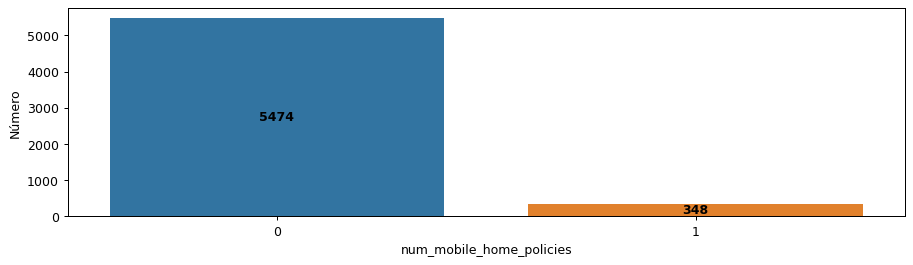

In [38]:
plot_feature(data,'num_mobile_home_policies')

### Tipos: Variables ordinales, nominales y numéricas.
En el fichero de maetadatos tenemos alamcenados la naturaleza de cada feature según las definiciones del diccioanrio del dataset, de manera que de manera sencilla transformaremos al dtype correspondiente. Entre las cateóricas, distinguiremos entre las nominativas ( ordened=False) y las ordinales ( orddened = True)
Las categorias nominales se corresponde con customer_type, customer_subtipe y el target, polizas caravanas, SI o NO.
LaAs categorias ordinales se corresponden con todas las características socioeconomicas salvo um_houses_1_10 y avg_size_household_1_6 que son numéricas, y todas las caractersiticas de cliente con datos de volumen de primas. 
Lss numéricas son todos los números de seguros de cliente, y las dos socioeconómicas nombradas anteriormente.

Sí ha creado alguna característica nueva (ejem.: source), se asigna como nominativa.


In [39]:

diccionario.categoria.value_counts()

ordinal    60
numero     23
nominal     3
Name: categoria, dtype: int64

In [40]:
lista_categorias = diccionario[diccionario['categoria'].isin(['nominal','ordinal'])]['feature'].tolist()

In [41]:
lista_numericas = diccionario[diccionario['categoria'] == 'numero']['feature'].tolist()

In [42]:
# Comprobamos que tratamos todas las variables
len(lista_categorias) + len(lista_numericas)

86

In [43]:
# transformamos todas las variables categoricas iniciales segun los metadatos.
data[lista_categorias] = data[lista_categorias].astype("category")
for col in lista_categorias:
    lista = diccionario[diccionario.feature == col]['posibles_valores'].tolist()
    lista = lista[0]
    if diccionario.loc[diccionario.feature==col,'categoria'].iat[0] == 'ordinal':
        data[col] = data[col].cat.set_categories(lista, ordered=True)

In [44]:
# Si existe alguna variable no comtemplada en el dataset original ( ej. souece) a categoy, ordened false.
lista_creadas=[x for x in data.columns.tolist() if x not in lista_categorias+lista_numericas] 
if len(lista_creadas)>0:
    data[lista_creadas] = data[lista_creadas].astype("category")

In [45]:
# Comprobamos la asignación de tupos.
data.dtypes.astype(str).to_frame().rename(columns={0:'tipo'}).value_counts()

tipo    
category    63
int64       23
dtype: int64

### Aproximación a la variable oculta: Area geográfica.

En la descripción de las tablas porporcionadas por los organizadores del concuros detectamos que se ha enmascarado el código postal de los clientes. Aquellos clientes en los que coincidan todos los datos socioeconomicos, tienen la dirección en le mismo código postal. Vamos a intentar hacer ingenieria inversa de esa caracterisitica.
Somos consientes que sí dos zips, tienen las 43 caracterisiticas socioeconómicas iguales no podremos distinguirlos.

No sabemos sí será de alguna utilidad, pero lo hacemos.

In [46]:
variables_socecon=data.iloc[:,0:43].columns.tolist()

In [47]:
# Generamos una serie boolena donde True indica que los 43 valores están repetidos.
duplicados=data[variables_socecon].duplicated(keep='first')

In [48]:
# Lo añadimos como una coumna en data.
data['duplicado']=duplicados.tolist()

In [49]:
# Generamos un frame con las filas de data no repetidos en datos socioeconomicoa
unicos=data[data.duplicado==False].reset_index(drop=True)
# Generamos los zips, asigandole el indice. Comenzará en 0 ...
unicos['zip']=unicos.index.tolist()
# Asignamos como indice de esta tabla todas las cariables socioeconomicas.
unicos=unicos.reset_index(drop=True).set_index(variables_socecon)

In [50]:
# Controlamos no hacer procesos repetidos de asignacion de zips.
if 'zip' not in data.columns:
    # Fijamos ocmo indice de data las 43 variables socioeconomicas.
    data=data.reset_index(drop=True).set_index(variables_socecon)
    # Mapeamos con la columna zip del frame unicos como diccionario, y la convertimos en category, nominal
    data['zip']=data.index.map(unicos.zip.to_dict()).astype('category')
    # Anulamos el indice de 43 caracterisiticas y borramos la columna duplicado en data y 
    data=data.reset_index().drop('duplicado',axis=1)
    

Podemos observar que son muy dispersos se generan 1734 códigos para train y 2177 sí estudiamos train y test.
Le hecho que se añadan nuevos zips en test es un problema, que habrá que solucionar a la hora de construir modelos, dependiendo de como dividamos la muestra en train y test. 
La consideramos interesante, y la conservamos por la posibilidad de poder prescindir de 43 columnas y agruparlas en 1.

In [51]:
data.zip.nunique()

1734

In [52]:
clientes_por_zip=data.zip.value_counts().sort_values(ascending=False).to_frame().reset_index(drop=True)
#clientes_por_zip.groupby('zip').count()
clientes_por_zip = clientes_por_zip.value_counts().sort_index().to_frame().reset_index()
clientes_por_zip= clientes_por_zip.rename({'zip':'clien_zip',0:'numero'},axis=1)
zips_1=clientes_por_zip[clientes_por_zip.clien_zip == 1]['numero'].iat[0]
zips_max=clientes_por_zip['clien_zip'].max()
zips_mean=clientes_por_zip['clien_zip'].mean()

print(f'Existen {zips_1} con un úncio cliente.')
print(f'El zip con mas clientes tiene {zips_max} clientes.')
print(f'La media de clientes por zip es {zips_mean} .')

Existen 725 con un úncio cliente.
El zip con mas clientes tiene 34 clientes.
La media de clientes por zip es 13.0 .


Parece que los cóidgos postales son muy dispersos. Existen codigos postales en el det de test que no existen en el set de train.
Dada la dispersión, nos hace poner en duda la exactitud de los datos socioedonomicos, incluidos los de segmentación de clientes. Es muy dificil que de estadisticas oficiales, de donde suelen proceder los datos, se llegue al nivel de código postal.

## Separación en train y test estratificado
Aunque comentado ya que aqui nos dan la división entre train y test, dejamos el código que permitirí dividir el conjunto de datos en train y test.

In [53]:
# asignamos a None la variable data_train, que nos permitrá controlar sí se ha realizado la división forzada de un dataset.
data_train=None

In [54]:
'''
# asignamos a None la variable data_train, que nos permitrá controlar sí se ha realizado la división forzada de un dataset.
data_train=None
from sklearn.model_selection import train_test_split
X_data, X_data_test, y_data, y_data_test = train_test_split(data.drop('num_mobile_home_policies',axis=1), 
                                                                     data['num_mobile_home_policies'], 
                                                                     stratify=data['num_mobile_home_policies'], 
                                                                     test_size=0.2)
data_train = pd.concat([X_data, y_data],axis=1).drop('source',axis=1)
data_test = pd.concat([X_data_test, y_data_test],axis=1).drop('source',axis=1)

for dataset in [X_data, X_data_test]: dataset.drop('source',inplace=True,axis=1)

print('== Train\n', data_train['num_mobile_home_policies'].value_counts(normalize=True))
print('== Test\n', data_test['num_mobile_home_policies'].value_counts(normalize=True))
'''

"\n# asignamos a None la variable data_train, que nos permitrá controlar sí se ha realizado la división forzada de un dataset.\ndata_train=None\nfrom sklearn.model_selection import train_test_split\nX_data, X_data_test, y_data, y_data_test = train_test_split(data.drop('num_mobile_home_policies',axis=1), \n                                                                     data['num_mobile_home_policies'], \n                                                                     stratify=data['num_mobile_home_policies'], \n                                                                     test_size=0.2)\ndata_train = pd.concat([X_data, y_data],axis=1).drop('source',axis=1)\ndata_test = pd.concat([X_data_test, y_data_test],axis=1).drop('source',axis=1)\n\nfor dataset in [X_data, X_data_test]: dataset.drop('source',inplace=True,axis=1)\n\nprint('== Train\n', data_train['num_mobile_home_policies'].value_counts(normalize=True))\nprint('== Test\n', data_test['num_mobile_home_policies'].value

In [55]:

# Adaptamos a que se no se haya hecho division forzada entre train y test. 
# Si solo se ha leido un fichero los asignamos a train.
# Si se leen dos ficheros se divide por el nombre del fichero origen del dato.
if data_train is None:
    if 'source' in data.columns:
        data_train=data[data.source=='ticdata2000']
        data_test =data[data.source=='ticeval2000'] 
        data_train=data_train.drop('source',axis=1)
        data_test= data_test.drop('source',axis=1)
    else:
        data_train=data

### Visión final de clases y descripción númerica de las variables.

In [56]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   customer_subtype                       5822 non-null   category
 1   num_houses_1_10                        5822 non-null   int64   
 2   avg_size_household_1_6                 5822 non-null   int64   
 3   avg_age                                5822 non-null   category
 4   customer_type                          5822 non-null   category
 5   roman_catholic                         5822 non-null   category
 6   protestant                             5822 non-null   category
 7   other_religion                         5822 non-null   category
 8   no_religion                            5822 non-null   category
 9   married                                5822 non-null   category
 10  living_together                        5822 non-null   categ

In [57]:
data_train.describe(include=['category']).T

,count,unique,top,freq
customer_subtype,5822,40,33,810
avg_age,5822,6,3,3000
customer_type,5822,10,8,1563
roman_catholic,5822,10,0,3228
protestant,5822,10,4,1607
...,...,...,...,...
contrib_bicycle_policies,5822,2,0,5675
contrib_property_policies,5822,7,0,5777
contrib_social_security_policies,5822,5,0,5740
num_mobile_home_policies,5822,2,0,5474


In [58]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
num_houses_1_10,5822.0,1.110615,0.405842,1.0,1.0,1.0,1.0,10.0
avg_size_household_1_6,5822.0,2.678805,0.789835,1.0,2.0,3.0,3.0,5.0
num_private_third_party_insurance,5822.0,0.402954,0.492631,0.0,0.0,0.0,1.0,2.0
num_third_party_insurance_firms,5822.0,0.014772,0.134133,0.0,0.0,0.0,0.0,5.0
num_third_party_insurane_agriculture,5822.0,0.020611,0.142092,0.0,0.0,0.0,0.0,1.0
num_car_policies,5822.0,0.562178,0.604767,0.0,0.0,1.0,1.0,7.0
num_delivery_van_policies,5822.0,0.010477,0.129991,0.0,0.0,0.0,0.0,4.0
number_motorcycle_scooter_policies,5822.0,0.041051,0.228974,0.0,0.0,0.0,0.0,8.0
num_lorry_policies,5822.0,0.002233,0.062819,0.0,0.0,0.0,0.0,3.0
num_trailer_policies,5822.0,0.012539,0.125775,0.0,0.0,0.0,0.0,3.0


Los estadisticos no nos dan información muy representativa. Nos indica que el conjunto de los clientes viven en codigos postales donde la mayoria de los habitantes son propietarios de una casa, que vivien  en codigos postales donde las familias mas abudantes son las de 2 ó 3 personas. Con respecto a los seguros, la media nos indica simplemente el total de seguros entre el número de clientes, el estudio de cuotas nos da información mas relevante.
COmo se puede observar el ramo que tiene un cliente con mas seguros es auto, con 12 pólizas.
Para todos los seguros el 3 cuarti son 0 ó 1 seguro, indicandonos que la mayoria de los clientes no tienen mas de un seguro por ramo.

Para las variables categóricas, nuestro diccionario da mejor información.

In [59]:
diccionario[diccionario.categoria.isin(['ordinal','nominal'])]

,feature,nombre,descripcion,categoria,clave,tipologia,valores_unicos,perc_cero,posibles_valores,mas_frecuente,maximo,minimo
0,customer_subtype,MOSTYPE,Customer Subtype,nominal,L0,socioeconomica,40,0.000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...",33,41,1
3,avg_age,MGEMLEEF,Avg age see L1,ordinal,L1,socioeconomica,6,0.000,"[1, 2, 3, 4, 5, 6]",3,6,1
4,customer_type,MOSHOOFD,Customer main type see L2,nominal,L2,socioeconomica,10,0.000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",8,10,1
5,roman_catholic,MGODRK,Roman catholic see L3,ordinal,L3,socioeconomica,10,55.445,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0,9,0
6,protestant,MGODPR,Protestant ...,ordinal,L3,socioeconomica,10,1.340,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",4,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60,contrib_boat_policies,PPLEZIER,Contribution boat policies,ordinal,L4,cliente,7,99.433,"[0, 1, 2, 3, 4, 5, 6]",0,6,0
61,contrib_bicycle_policies,PFIETS,Contribution bicycle policies,ordinal,L4,cliente,2,97.475,"[0, 1]",0,1,0
62,contrib_property_policies,PINBOED,Contribution property insurance policies,ordinal,L4,cliente,7,99.227,"[0, 1, 2, 3, 4, 5, 6]",0,6,0
63,contrib_social_security_policies,PBYSTAND,Contribution social security insurance policies,ordinal,L4,cliente,5,98.592,"[0, 2, 3, 4, 5]",0,5,0


## Descripción gráfica

### Visualización variables socieconómicas.

Ofrecemos visiualización de las variables socioeconomicas. Sabemos que este tipo de variables no son de cliente, represetnan el valor que toma cada variable en el area geofrafica donde vive el clinte. Así para num_house_1_10, nos indica que 5.267 clientes (para el set de train) vivien en zonas donde el conjunto de la poplación es dueña de una vivienda, 505 clientes viven en areas donde mayotitariamente son propietarios de 2 viviendas.

Para average_edad, la categoria 3 singnifica que son zonas donde mayoritariamente vivien personas entre 40-50 años (L1). PAra el conjunto de train, son 3.000 clientes los que viven en este tipo de zonas.

El gráfico de la derecha, representa la proporción de clientes ue tienen seguro de caravana dentro de cada nivel de la variable estuidada. 

No proporciona mucha información, dada la poca presencia de seguros de caravanas,  se observa cierta relación positiva la zoans donde las variables de renta y poder adquisitivo son altos. Pero al ser una representación colectiva de una zona, nos caracteriza area geográfica, no cliente individual.

Las iremos graficando agrupadas por temáticas.

#### Relacionadas con la vivienda, tamaño del hogar y edad.
Las variables de edad y tamaño de la vivienda presentan distribuciones cuasi normales. LA mayoria de la divisiones geograficas deben de tener de entre 40 y 50 años, y por ende, la distribución de los clientes de la muestra la reproduce. El número de personas que componen los hogares deben de ser 3, y así se reproduce en los clientes de la muestra.
En cuanto al número de viviendas, existen distritos donde mayoritaríamente tienen de 1 a 9 viviendas. Pero la absoluta mayoria son distritos donde predominan los propietrios de 1 viviendas.
Con respecto al cruce con seguro caravana, poco que decir, quizas que parece que se venden un poc mas en aquellas zonas donde el tamaño de laa familias es mas atlo. En cuanto a la edad, parece que los aficionados a las caravanas abubdan menos en las regiones con menor media de edad.

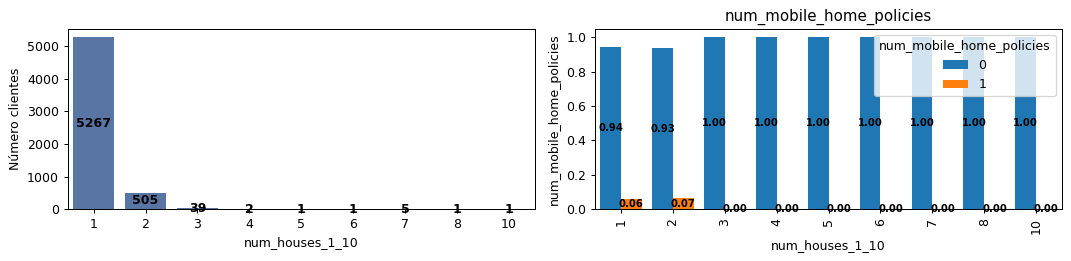

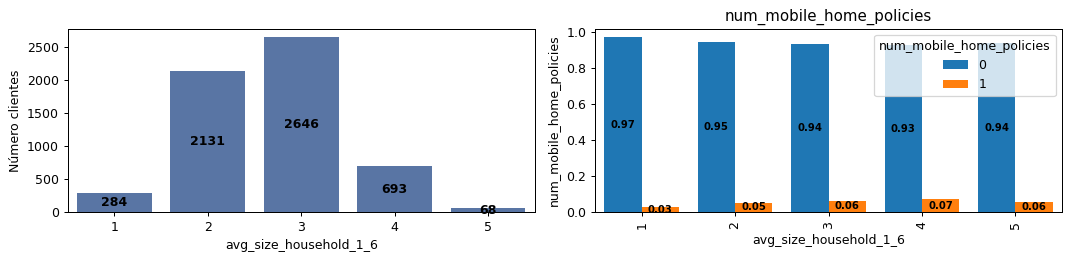

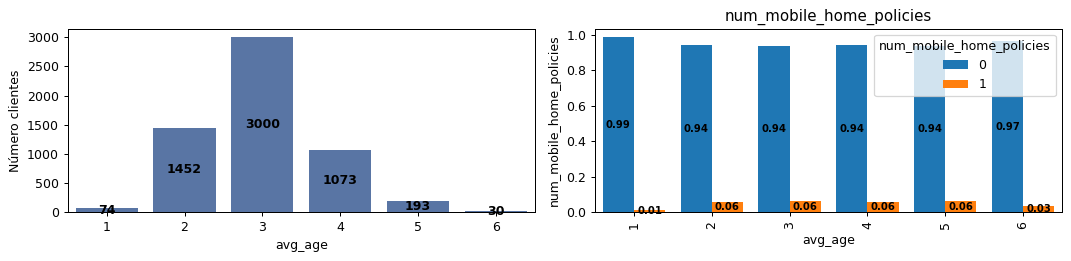

In [60]:
for i in  data_train.columns[1:4]:
    plot_feature(data_train, i)

#### Religión:

En la mayoria de los clientes vivien en zonas donde predomina la religión protestante o sin religión. No es de estrañar, ya que estamos hablando de Holanda. 

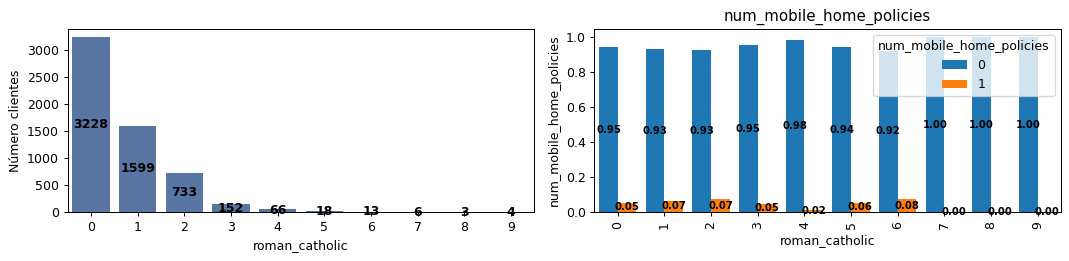

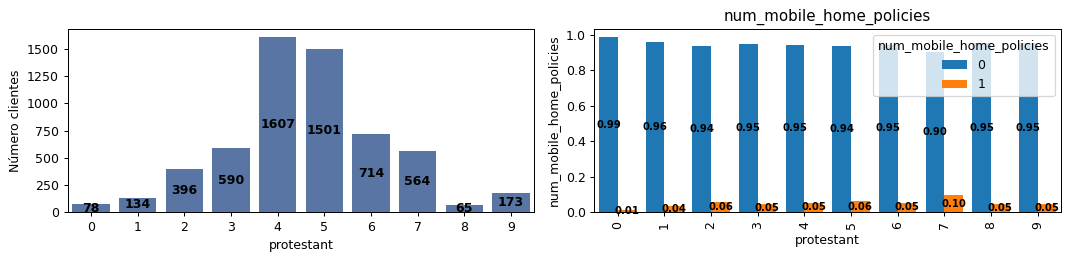

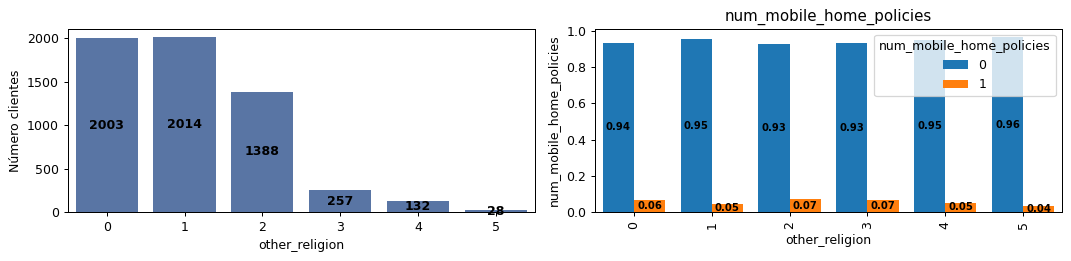

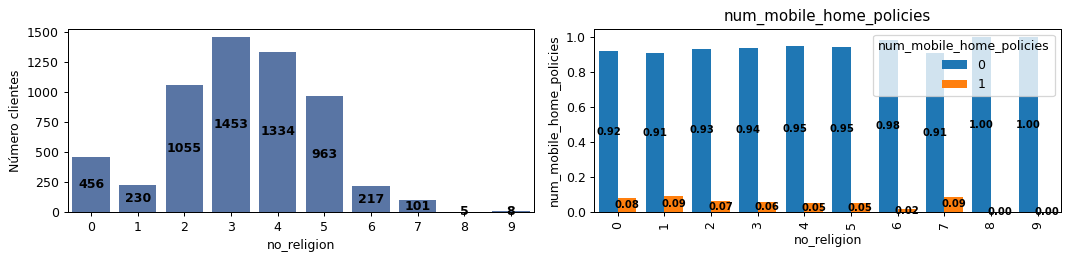

In [61]:
for i in  data_train.columns[5:9]:
    plot_feature(data_train, i)

#### Tipo de relación y hogares con niños.
La mayoria de los clientes vivien en zonas donde mas del 50 % de la población está casada. La mayoria de los cliente vivien en zonas donde entre el 40 % y 50 % de los hogares tienen niños. La proporcion de lcientes con seguro de caravana se mantiene mu ycercana a la media de la problación en todos los subsegmentos.


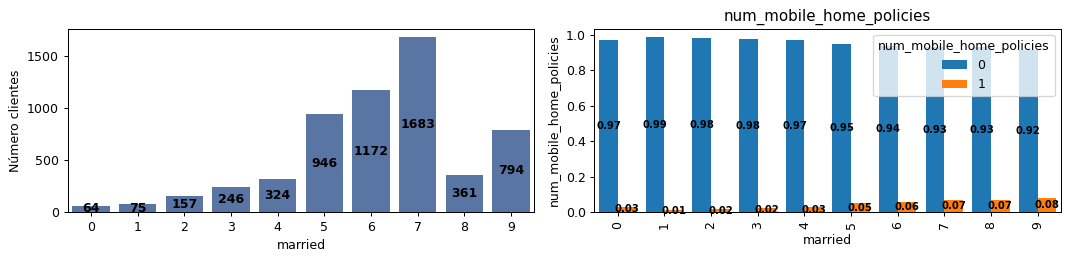

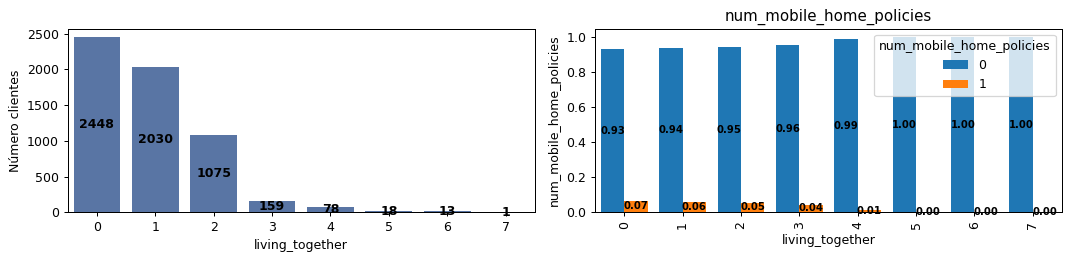

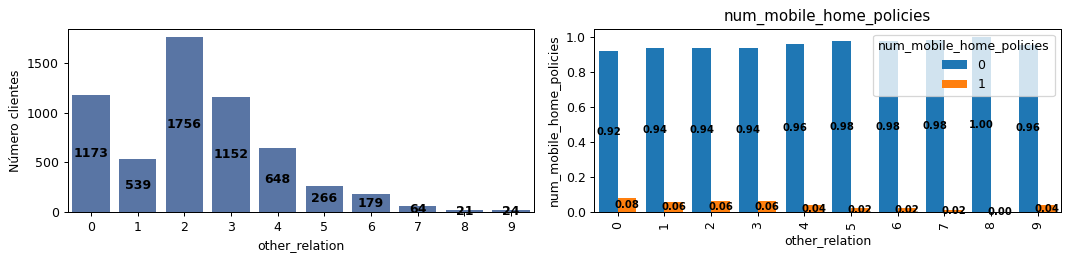

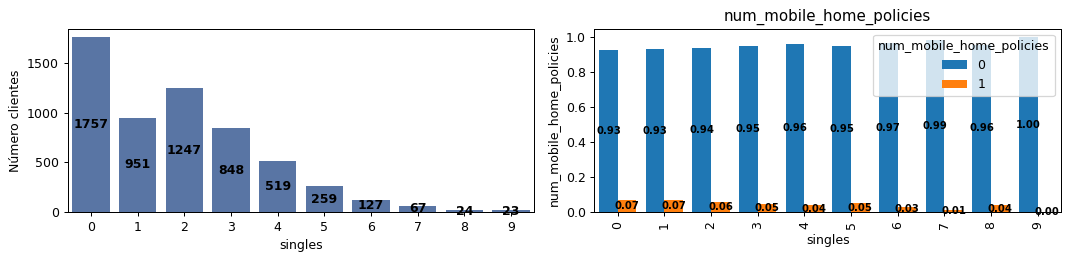

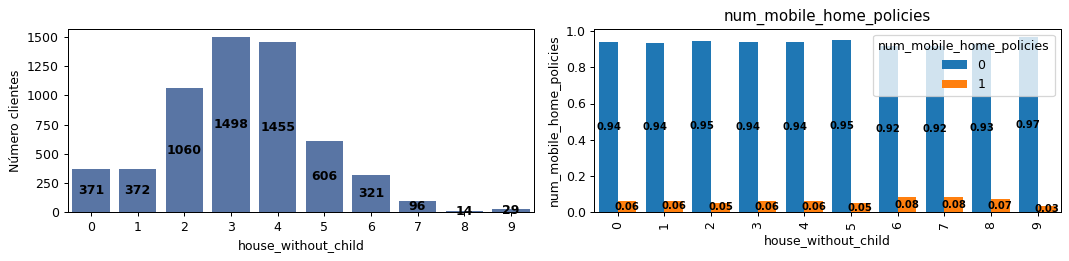

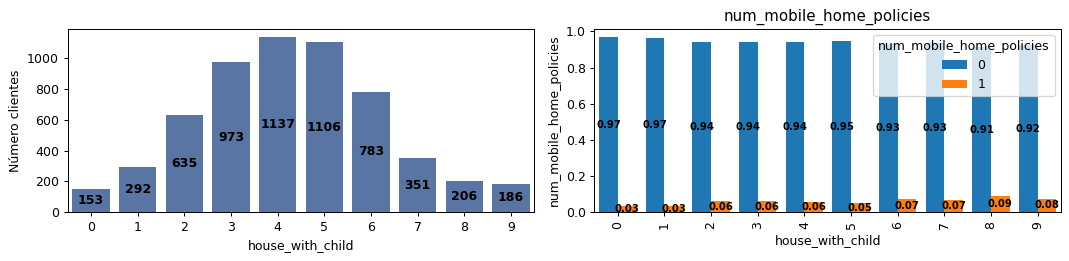

In [62]:
for i in  data_train.columns[9:15]:
    plot_feature(data_train, i)

#### Nivel educativo.
LA mayoria de los clientes vivien en zonas donde entre el 80 % de la población tiene niveles medios o bajos de formación. 

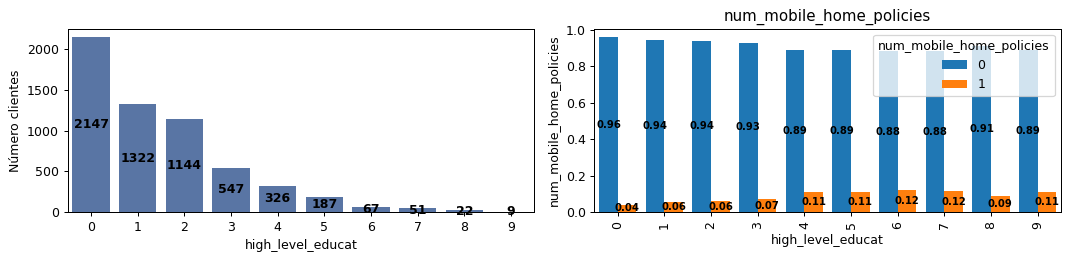

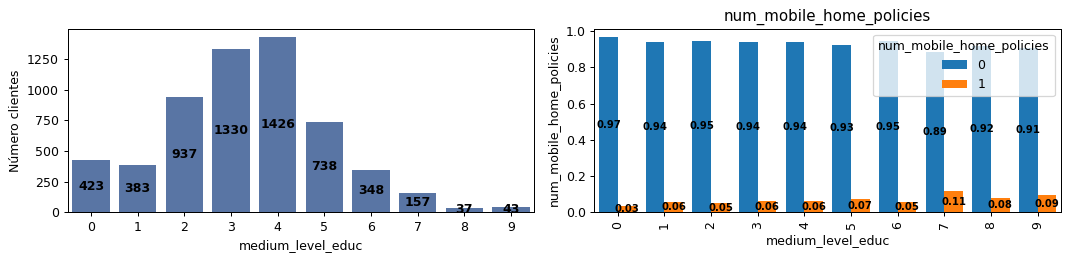

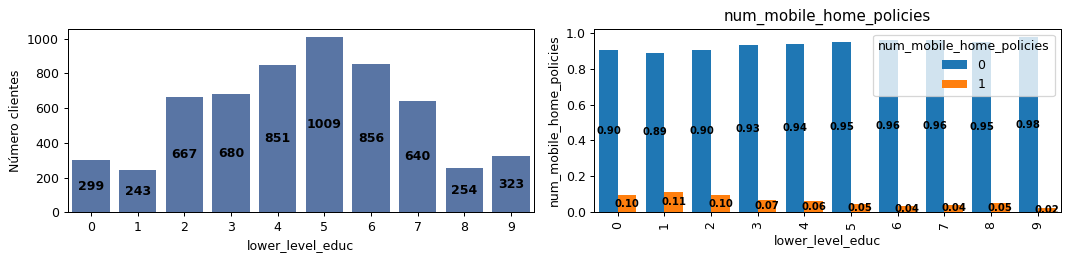

In [63]:
for i in  data_train.columns[15:18]:
    plot_feature(data_train, i)

#### Información de ocupación:

Son muy pocas regiones las que presentas aalta propoción de empresarios  yempresarios agricolas, como era de esperar presentan una propoción bastante pareja de trabajadores cualificados, mandos intermedios y trabajadores no cualificados.

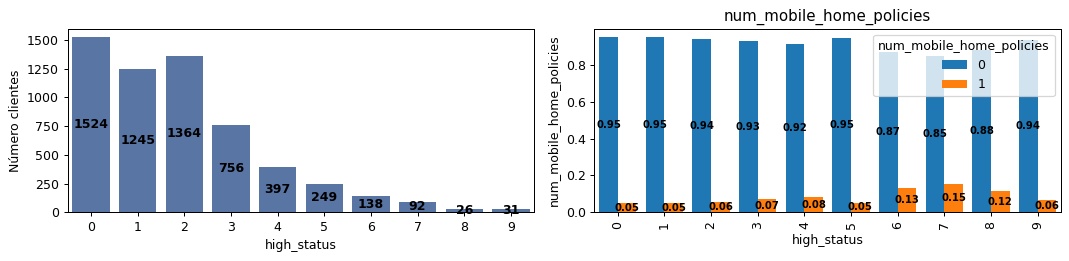

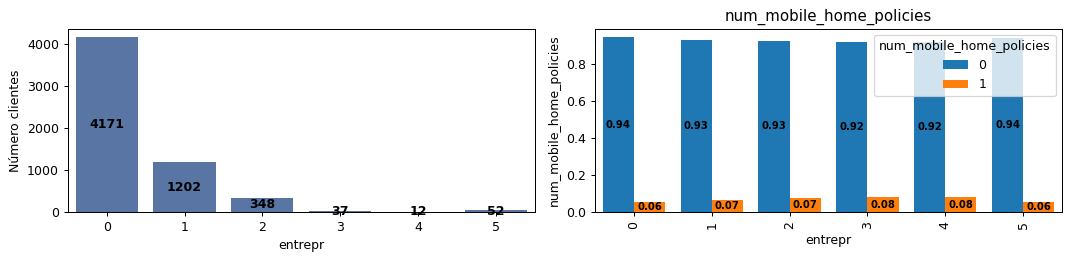

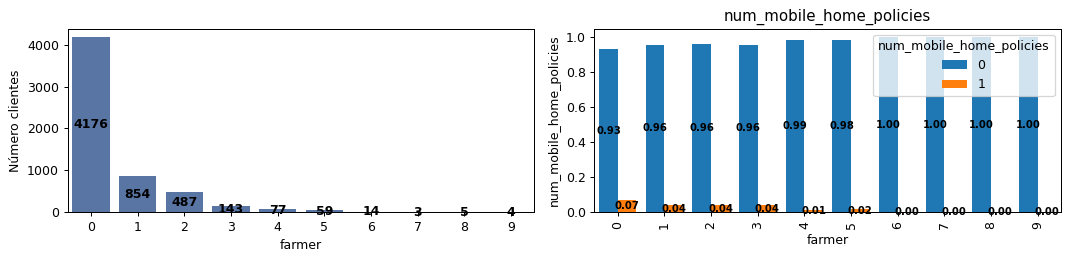

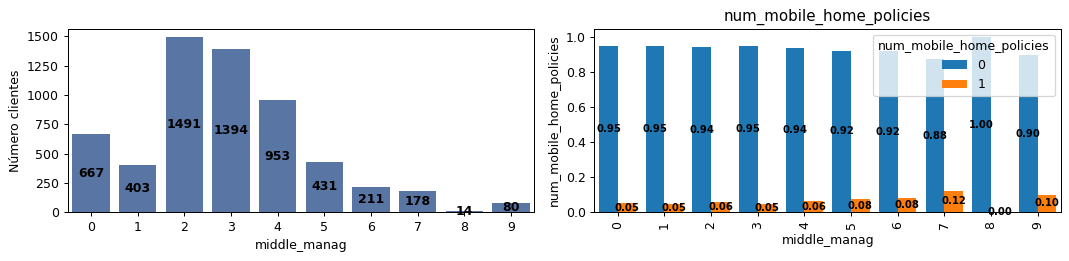

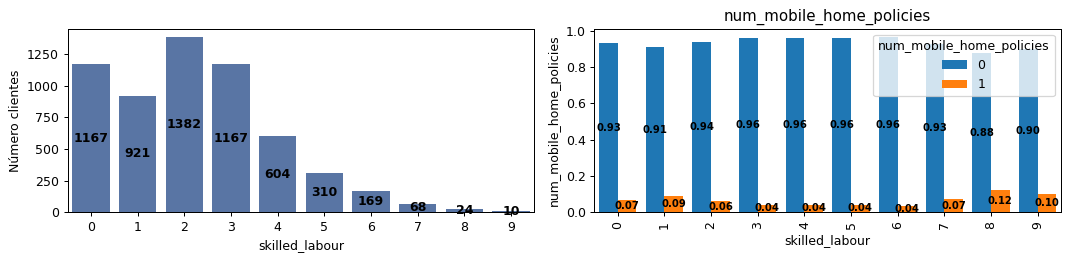

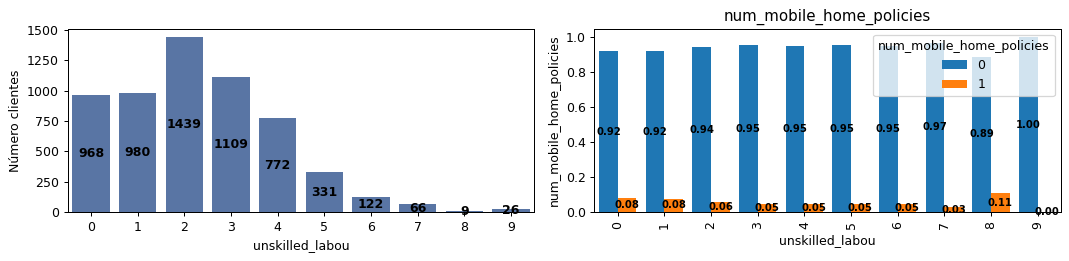

In [64]:
for i in  data_train.columns[18:24]:
    plot_feature(data_train, i)

#### Clasificación por clases sociales.

La mayoria de las zonas presentan mayoritariamente una mezcla de calse c (entendemos media-baja) y media.

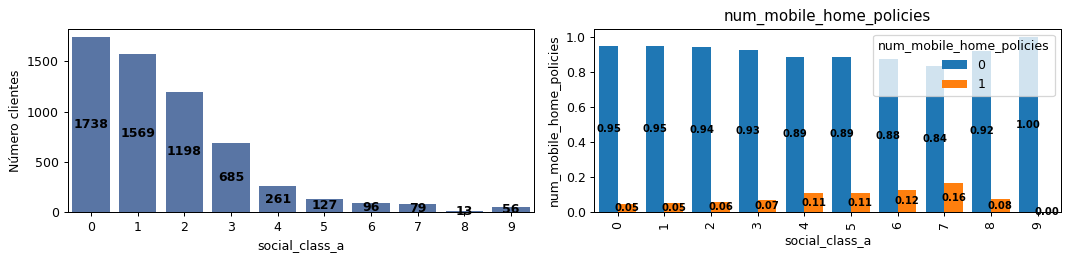

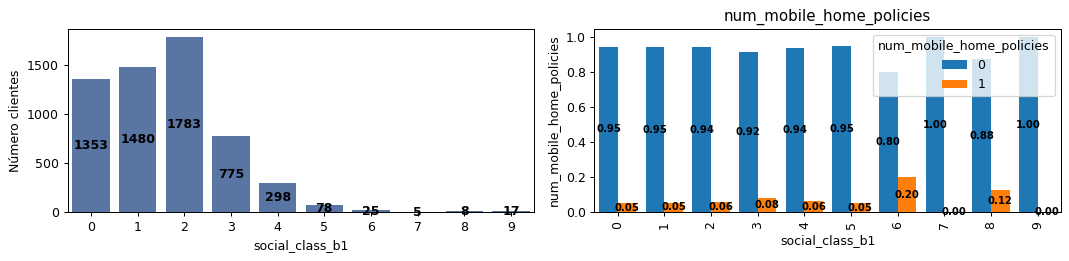

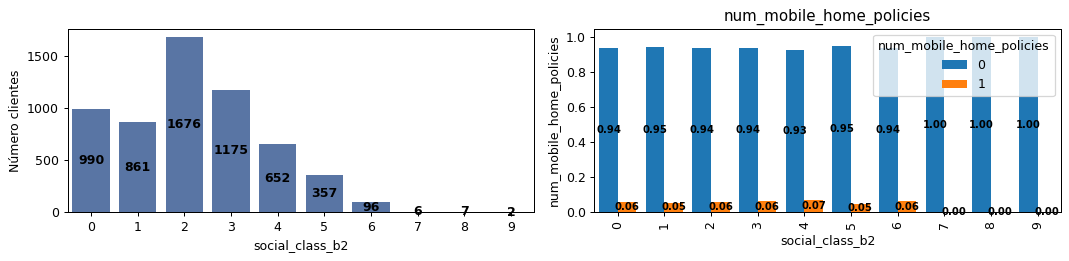

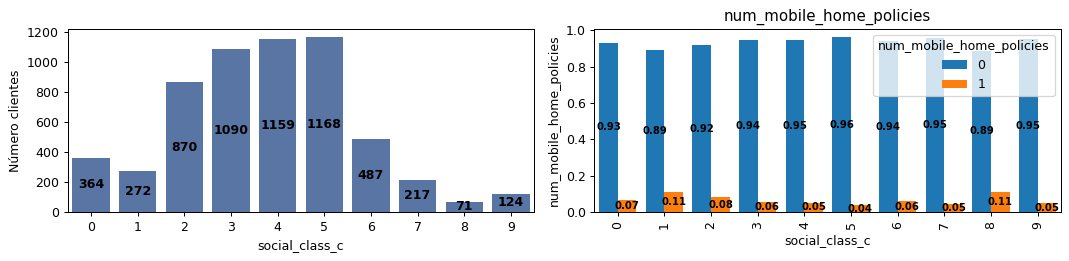

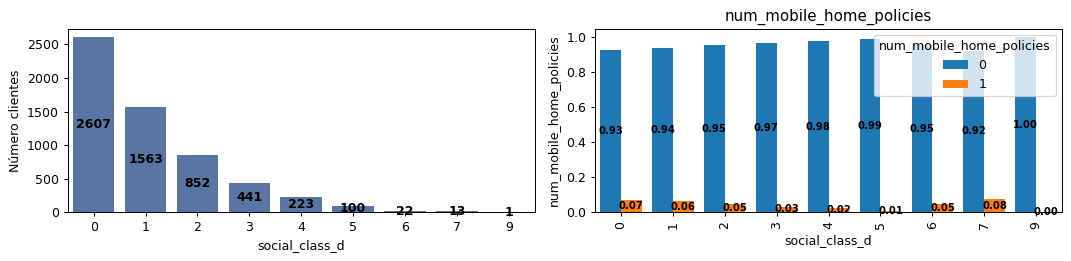

In [65]:
for i in  data_train.columns[24:29]:
    plot_feature(data_train, i)

####  Propiedad de la vivienda:
En esta dimensión existen mucha igualdad entre zonas en cuanto a los porcentajes de personas que viven de alquiler o tienen vivienda en propiedad. Al ser dicotomica se observa simetria entre ellas. El número mas grande de clientes vivien en zonas donde entre el 100 % son propierarios, pero existe una amplia gama de porcentajes preponderantes.

**Al tener una simetria casi perfecta nos podríamos plantear eliminar una de ellas.**

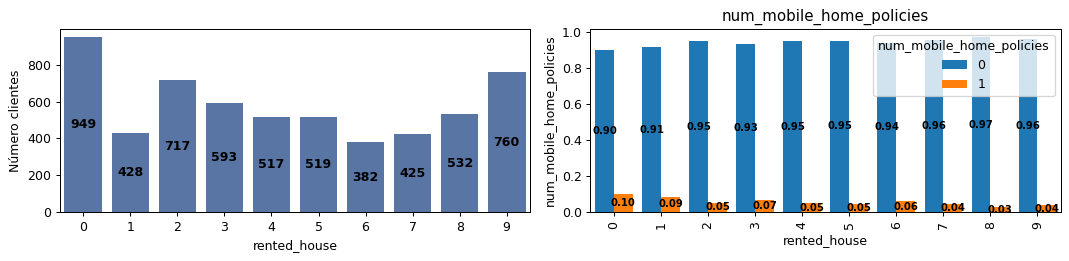

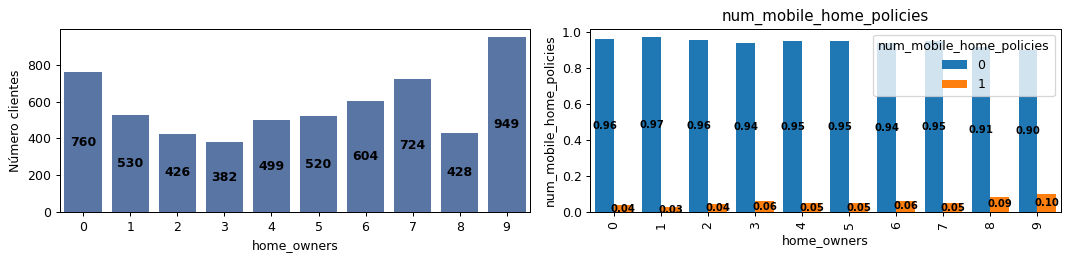

In [66]:
for i in  data_train.columns[29:31]:
    plot_feature(data_train, i)

#### Coche en propiedad.
Son absolutamente mayorias las zonas donde mas de un 50 % de la población posee un coche. Aunque sea bastante difusa, podemos intuir una relación creciente entre las regiones con mayor porcentaje de propietarios de vehículos y una mayor penetración del seguro de autocaravanas, e inversa para aquellas reiones donde es alto el porcentaje de la población sin vehiculo en propiedad.

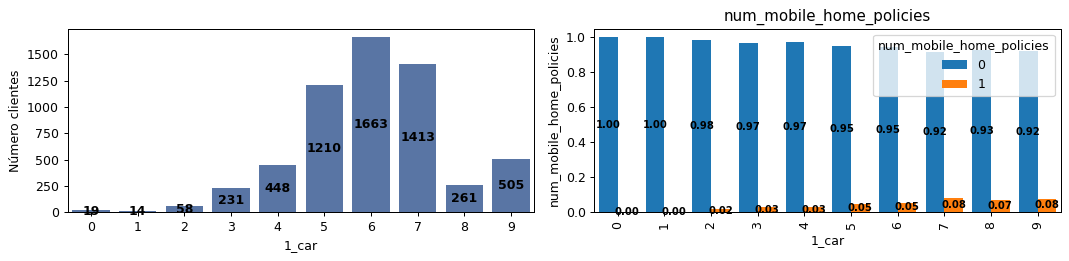

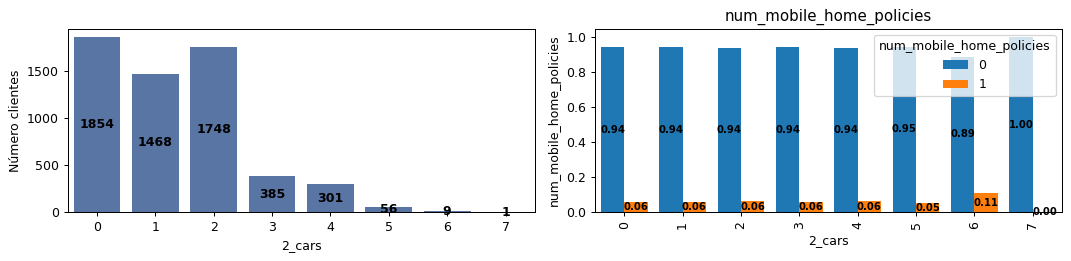

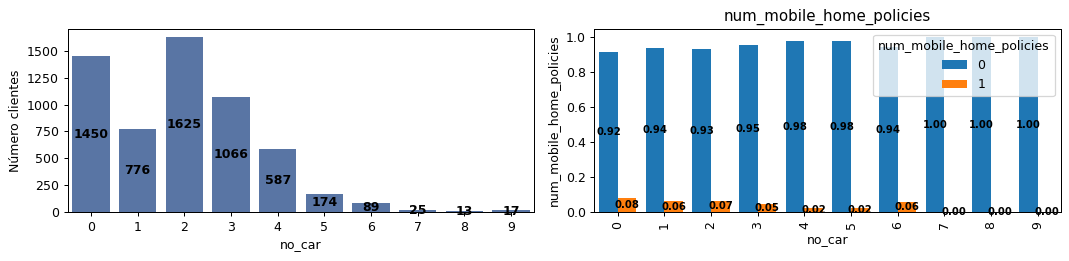

In [67]:
for i in  data_train.columns[31:34]:
    plot_feature(data_train, i)

#### Asistencia sanitaria pública o privada.
Mayoritariamente se opta en casí todas las zonas por la asistencia sanitaria pública.

**Al tener una simetria casi perfecta nos podríamos plantear eliminar una de ellas.**

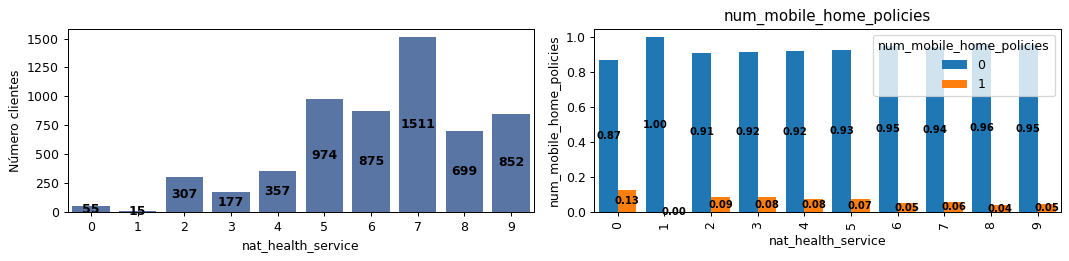

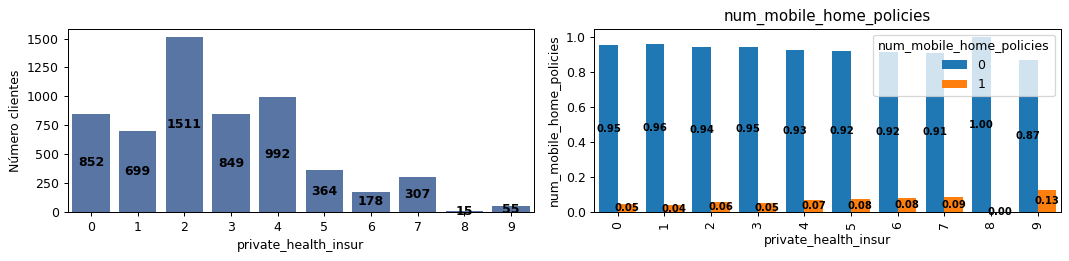

In [68]:
for i in  data_train.columns[34:36]:
    plot_feature(data_train, i)

#### Nivel de ingresos
Los ingresos medios de las regiones de la muestra se situan entre 30.000 y 75.000 €. 

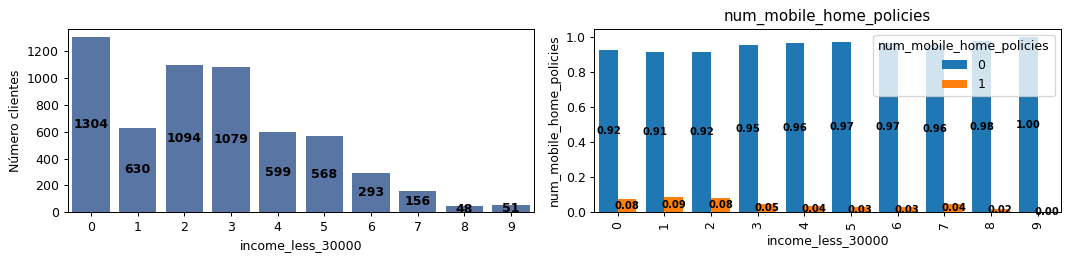

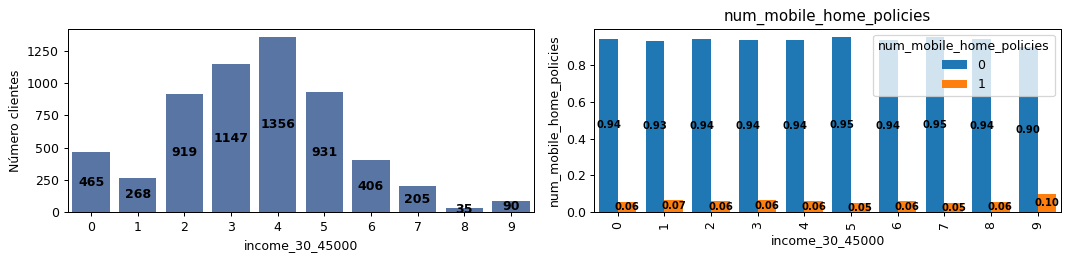

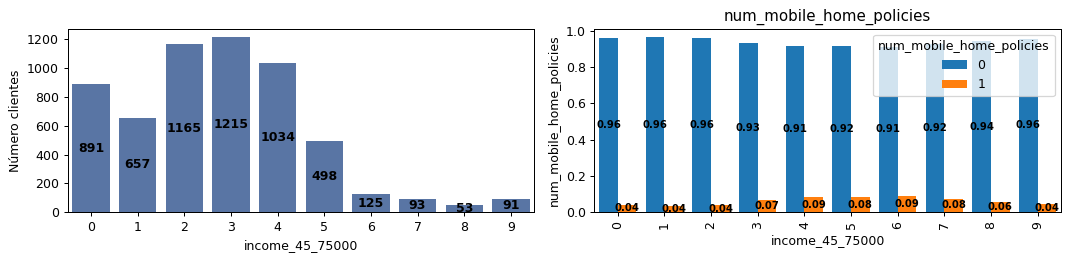

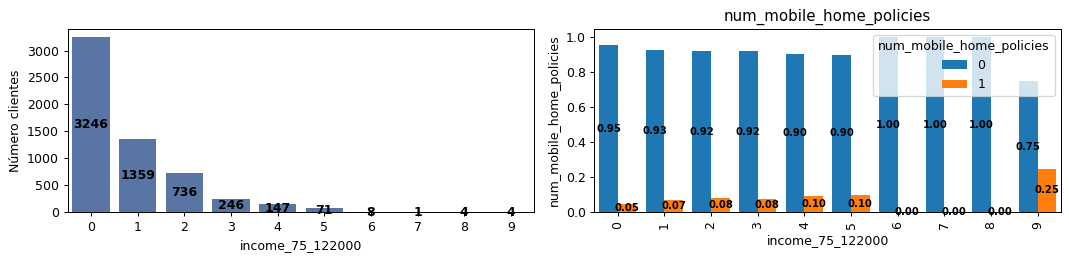

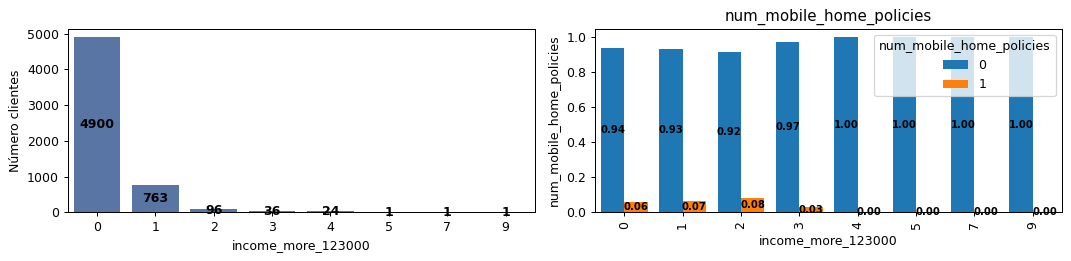

In [69]:
for i in  data_train.columns[36:41]:
    plot_feature(data_train, i)

#### Ingresos Medios y capacidad de compra.
No hemos localizado una tabla interpretativa de estas caracterisitcas, pero como vemos se situan en ingresos medios.

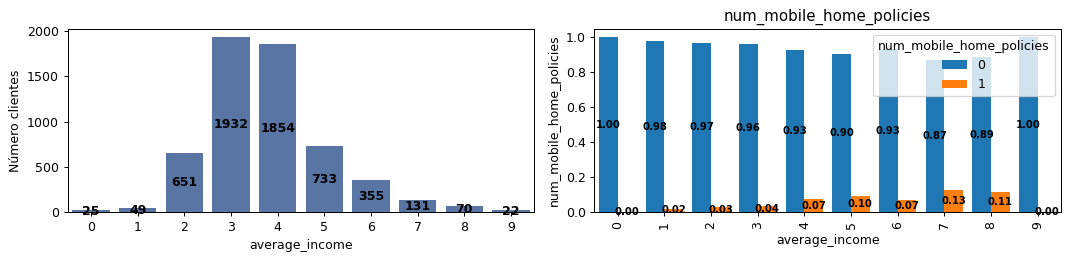

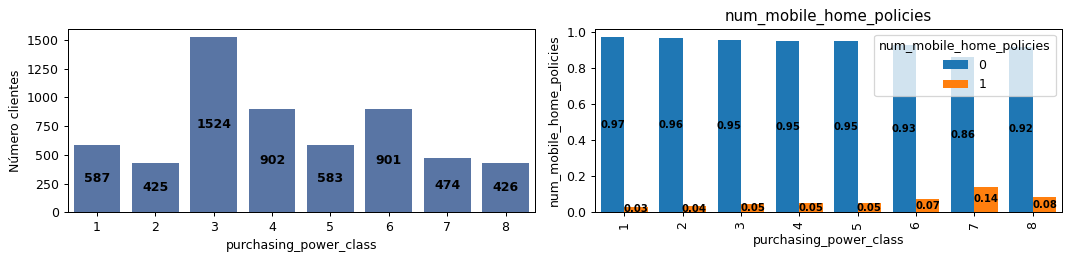

In [70]:
for i in  data_train.columns[41:43]:
    plot_feature(data_train, i)

#### Tipo y subtipo de cliente.
Observamos que cada tipo de cliente se agrupa en subdiviciones que no se mezclan entre si. Los grupos preponderantes en las regiones de la muestra son
familias con adultos (8), familias medias (3) y familias conservadoras (9). El subgrupo mas númeroso son Village families ( no sé si traducirlo por familias urbanas o de pueblo) con mas 800 clientes en zonas donde son preponderantes.

Observamos que la relación entre grupo y subgrupo es monotónica, por lo que no tenemos que exlcuirlas de la correlacion de spearman.

**Se podrá prescindir de la variable grupo, ya que dentro de cada subgrupo va a ser la misma.**

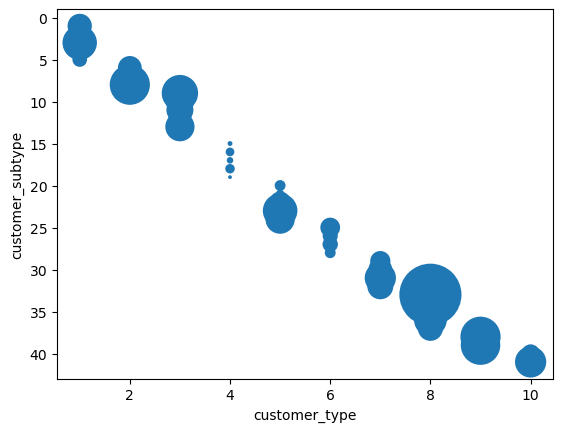

In [71]:
datos_buble=(data_train[['customer_type','customer_subtype','num_social_security_policies']].
             groupby(['customer_type','customer_subtype']).
             agg(['count','sum']).
             reset_index())
datos_buble=datos_buble.droplevel(1, axis='columns')
datos_buble.set_axis(['customer_type','customer_subtype','total','con _poliza'], axis=1,inplace=True)
sns.scatterplot(data=datos_buble,
                x='customer_type',
                y='customer_subtype',
                size= 'total',
                legend=False, 
                sizes=(0, 2000))
plt.show()

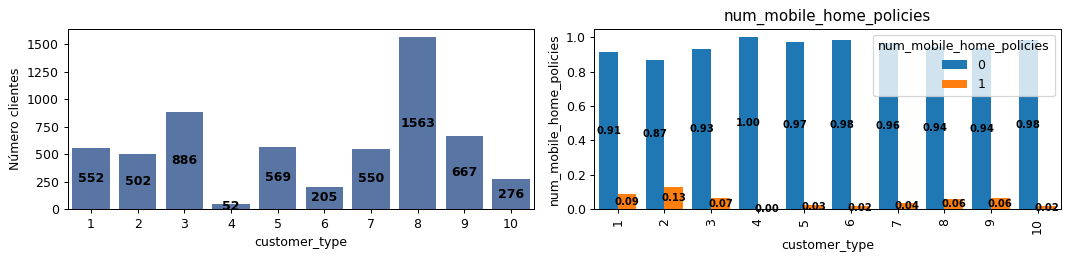

In [72]:
plot_feature(data_train, 'customer_type')

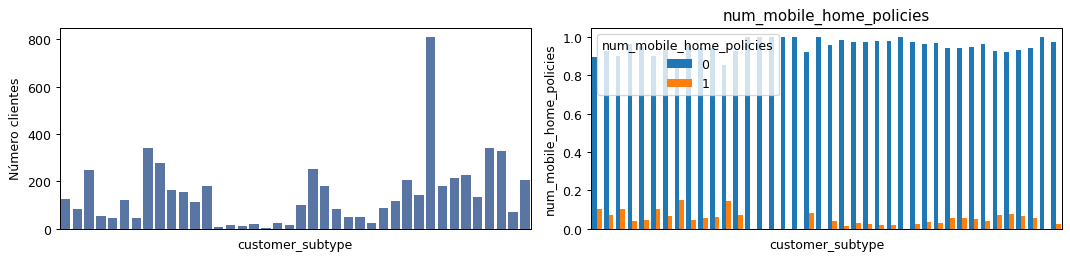

In [73]:
plot_feature(data_train, 'customer_subtype')

### Visualización variables de cliente.
Segmentaremos el estudio entre seguros comercializados masivamente y de baja comercializacion. Solo estudiaremos en profundidas los de comerciliacion masiva, incendios y coches. Se ofrece la muestra de lo que son seguros de comercialización testimonial, donde todas las representacioens son muy parecidad.

#### Seguros de comercialización masiva. Autos e indendios y pózas de otras compañias

Como hemos indicado un 50 % de los clientes titne una de estas polizas. Destaca que los el 15 % de titulares de 2 seguros de autos, ya tiene el seguro de caravana. El número máximo de pólizas contratadas de los dos ramos son 7 en el conjunto de train.

**Aqui surje un grupo interesante, los clientes que tienen una póliza de coche, muy numeroso 2712, y tirplica el porcentaje de la muestra que contiene el objetivo. PArece que se corresponde con clientes que presentan contribución 6 en autos.**

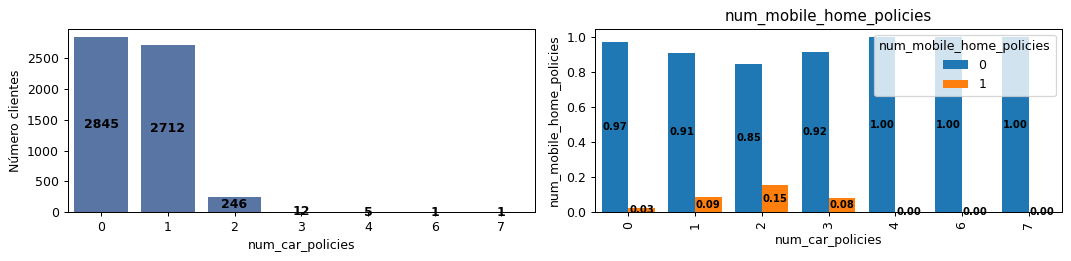

In [74]:
plot_feature(data_train, ramos_polizas[3])

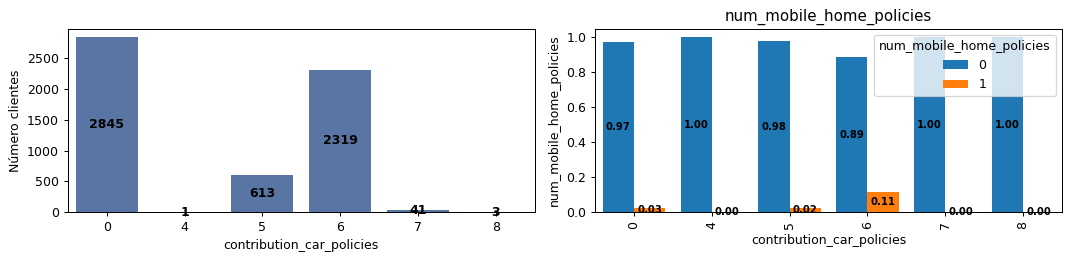

In [75]:
plot_feature(data_train, contribuciones[3])

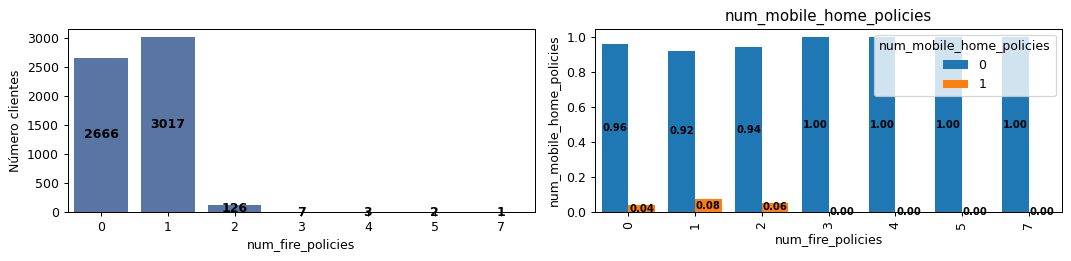

In [76]:
plot_feature(data_train, ramos_polizas[15])

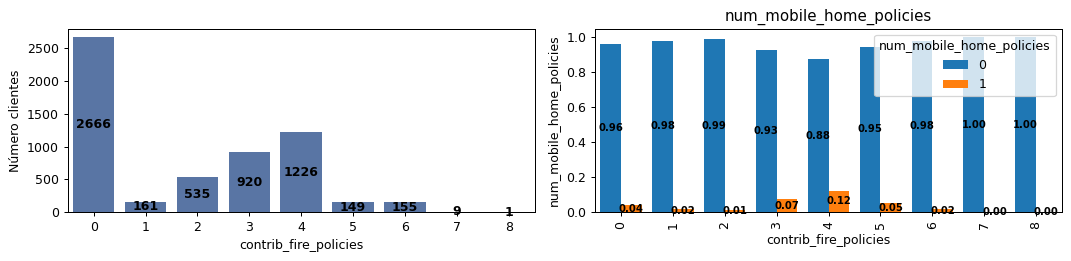

In [77]:
plot_feature(data_train, contribuciones[15])

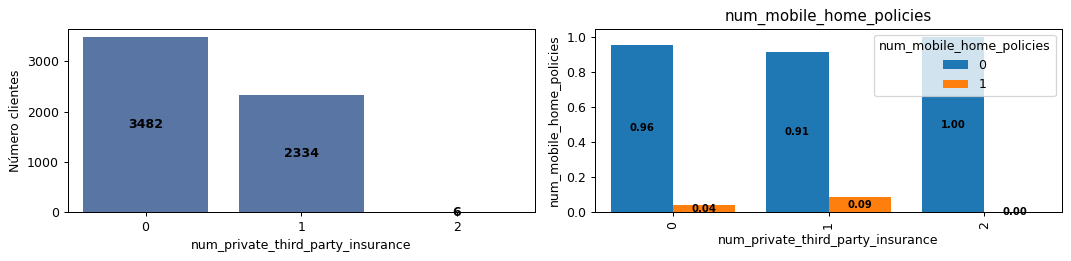

In [78]:
plot_feature(data_train, ramos_polizas[0])

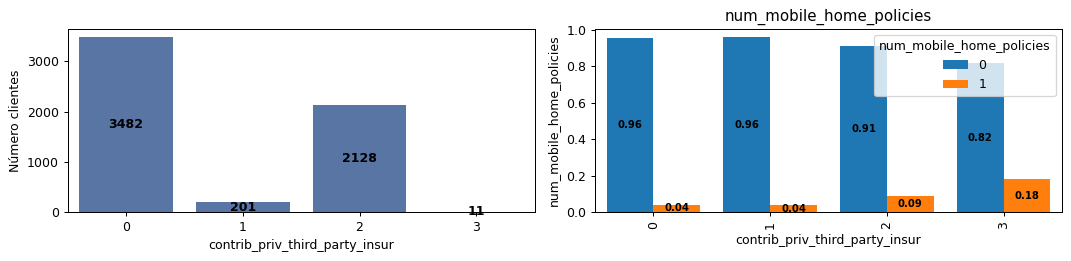

In [79]:
plot_feature(data_train, contribuciones[0])

Los demás seguros son de muy baja comercialización, estarán muy volcados en el valor 0. Como muestra ploteamos seguors de vida y de remolques. No los ploteamos todos, las representacioens van a ser muy similares con muy pocos clientes con alguna póliza contratadas.

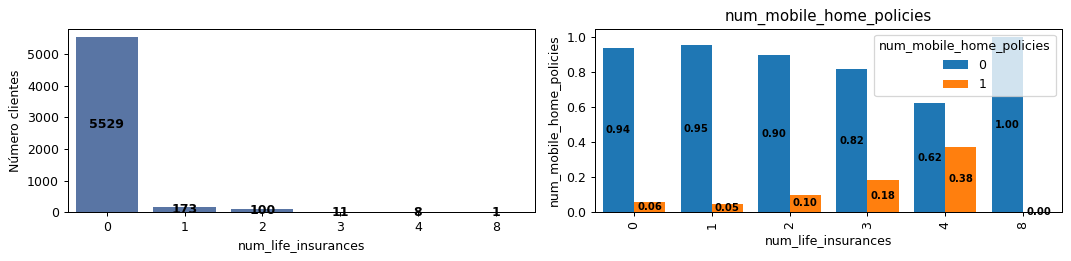

In [80]:
plot_feature(data_train, ramos_polizas[11])

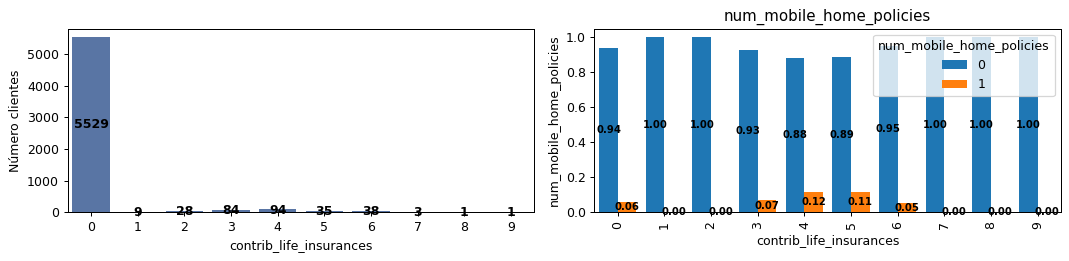

In [81]:
plot_feature(data_train, contribuciones[11])

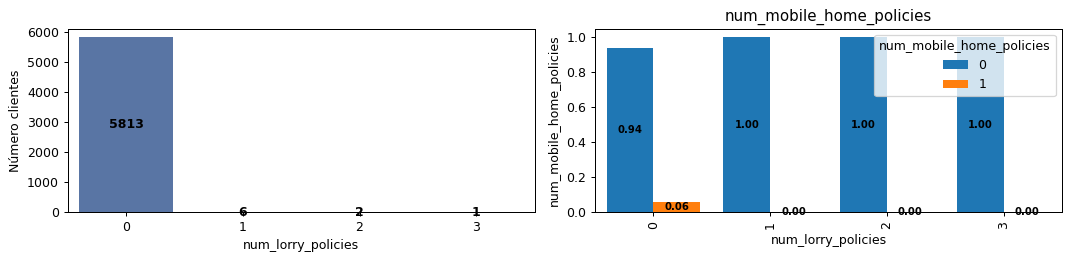

In [82]:
plot_feature(data_train, ramos_polizas[6])

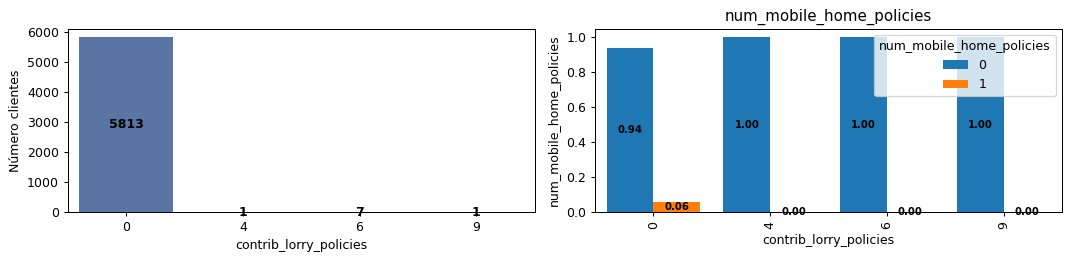

In [83]:
plot_feature(data_train, contribuciones[6])

## Detección outliers.

LA consideración de outliers en estos datos no es muy intiuitiva, dado que los datos están recovertidos en tramos de por la codificación. 
Primero, para calcular los intervalos, redondeamos la media y (mult por la desviación estandar) al entero mas cercano, no pueden existir fracciones de pólizas en la realidad, y nos permite hacer un estudio mas adecuado.
Al tener los datos númericos un porcentaje de ceros tan elevado,  todos los seguros de comercialización muy baja se marcan como ouliers. La columna tratable no, sigifica que todo los disitinto de 0 es considerado como oulier. Y la unica forma de eliminarlos, es eliminar la columna entera.

PAra el resto de seguros, tratables, se consierariían outlier, en cuanto contraten un número de 2 o mas seguros en la mayoria de los casos.

In [84]:
get_deviation_of_mean_perc(data_train,lista_numericas,'num_mobile_home_policies',3)

,0,1,feature,outliers_count,porcentaje_outlires,distintos_cero,tratables
0,0.940368,0.059632,num_surfboard_policies,5819,99.948471,5822,si
1,0.940134,0.059866,num_lorry_policies,5813,99.845414,5822,si
2,0.940010,0.059990,num_agric_machines_policies,5801,99.639299,5822,si
3,0.940679,0.059321,num_disability_policies,5799,99.604947,5822,si
4,0.940079,0.059921,num_priv_accident_policies,5791,99.467537,5822,si
5,0.942132,0.057868,num_boat_policies,5789,99.433184,5822,si
6,0.940871,0.059129,num_accidents_policies,5784,99.347303,5822,si
7,0.940627,0.059373,num_property_policies,5777,99.227070,5822,si
8,0.940076,0.059924,num_delivery_van_policies,5774,99.175541,5822,si
9,0.940594,0.059406,num_trailer_policies,5757,98.883545,5822,si


## Estudio correlaciones.
Vamos a estudiar las correlaciones por trés métodos. Pearson la reservaremos para variables númericas.
Spearman y Cramers, se la aplicaremos a todas las variables. Sabemos que conceplamente equivale a todas como categorias, situacion que se puede asemejar a la naturaleza de nuestros datos, al no existir ningna variable continua.
Sabemos que para Spearman ofrezca buenos reslutados, todas las relaciones deberían ser monotónicas, supuesto que intuitivamente para la mayoria de cruces, y probado en tipo y subtipo de cliente, se cumple.
Descartamos que Spearman funcione con zip, ya que aquí, descartamos que exista relación monotónica con el resto de variables.

### Pearson: 
Poco reveladora, relacioenes obvias, entre numero de seguros tractores y seguros agriculas.
Y con relaciones no muy consistentes, las máximas están en 0.37 y la minima en el entorno del 0.
Solo existen 7 pares de variables con correlacioens superiores a 0.15 en valor absoluto.

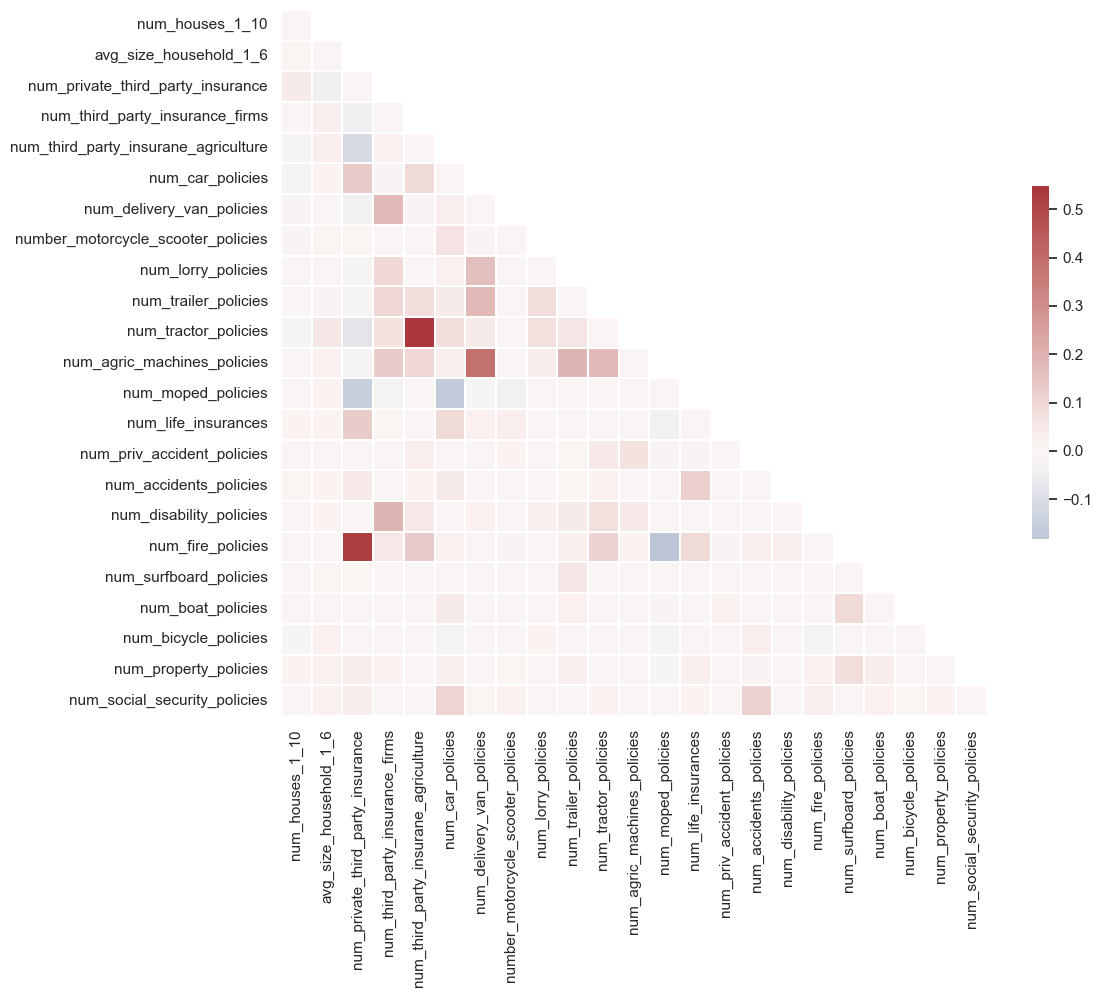

In [85]:
get_corr_matrix(dataset = data_train, isnumeric=True, size_figure=[12,10],limit=0)

In [86]:
top_correlation(data_train[lista_numericas],metodo='pearson',limit_inf=0.15,limit_sup=0.5)

,Variable_1,Variable_2,Correlacion
2,num_delivery_van_policies,num_agric_machines_policies,0.379082
3,num_trailer_policies,num_agric_machines_policies,0.193004
4,num_third_party_insurance_firms,num_disability_policies,0.191960
5,num_moped_policies,num_fire_policies,-0.183002
6,num_tractor_policies,num_agric_machines_policies,0.182645
7,num_delivery_van_policies,num_trailer_policies,0.181096
8,num_third_party_insurance_firms,num_delivery_van_policies,0.178323
9,num_delivery_van_policies,num_lorry_policies,0.165436
10,num_car_policies,num_moped_policies,-0.162322


### Spearman:
Aqui, comparando todo el dataset, se sacan muchas conclusiones.
1) Existe muy poca correlacion entre variables socioeconomicas y variables de cliente.
2) Intragrupos existen relaciones muy fuertes, y como veremos tiene toda la lógica.

Como habiamos anticipado Spearman no encuentrea correlaciones de zip con las variables socioecómicas.

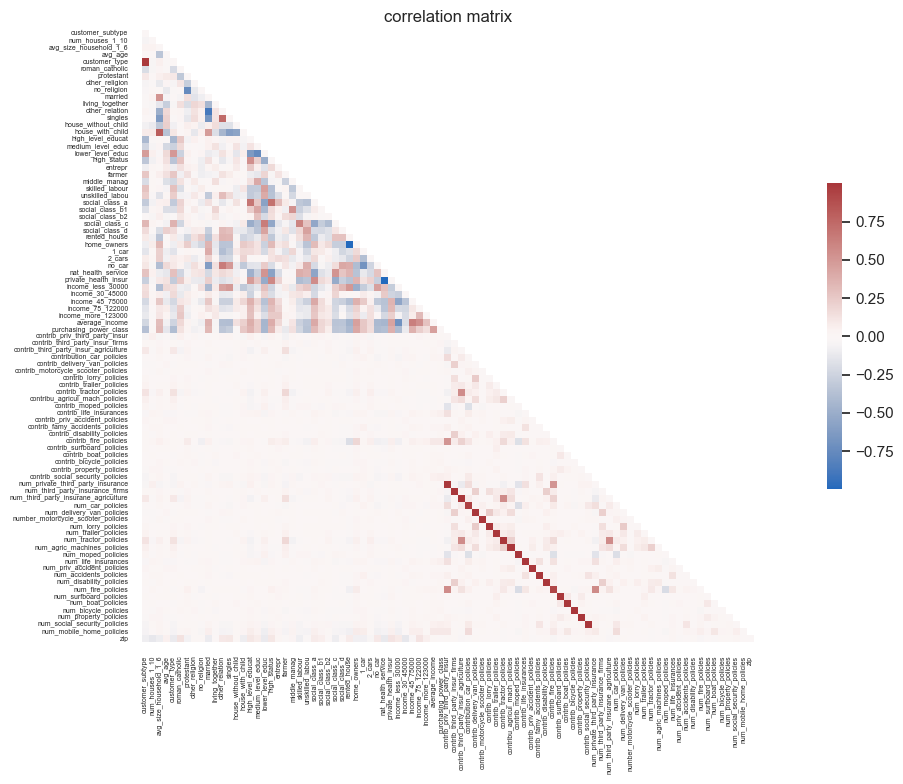

In [87]:
get_corr_matrix(dataset = data_train, isnumeric=False, size_figure=[12,10],limit=0,socioc_num=False)

In [88]:
top_correlation (data_train,metodo='spearman',limit_inf=0.9,limit_sup=1)

,Variable_1,Variable_2,Correlacion
0,contrib_surfboard_policies,num_surfboard_policies,1.000000
1,contrib_lorry_policies,num_lorry_policies,1.000000
2,contribu_agricul_mach_policies,num_agric_machines_policies,0.999999
3,contrib_disability_policies,num_disability_policies,0.999998
4,contrib_priv_accident_policies,num_priv_accident_policies,0.999996
5,contrib_famy_accidents_policies,num_accidents_policies,0.999995
6,contrib_boat_policies,num_boat_policies,0.999995
7,contrib_delivery_van_policies,num_delivery_van_policies,0.999994
8,contrib_property_policies,num_property_policies,0.999992
9,contrib_trailer_policies,num_trailer_policies,0.999989


Estudiemos solo las correlacioens intragrupos, dentro de las variables socioceconomicas y de cliente.
En las variables socioeconómicas encontramos correlaciones totales entre grupos dicotómicos (casa propietario o alquiler, seguridad social), entre grupo y subgrupo de cliente, altas correalcioens entre las dimensioens que miden cada caracterisitica cuando hay mas de dos posibilidades. Existen tambien alta correlación entre el tamaño de la familia y sí hay niños.

En las variables de cliente, las contribuciones y número de seguros para seguros de baja comercilización son totales. Para los seguros de comercialización masiva alta pero no total. El resto de correlacioens ya bajan a niveles de 0,50 para aquellas variables con clientes de seguros agrícolas.



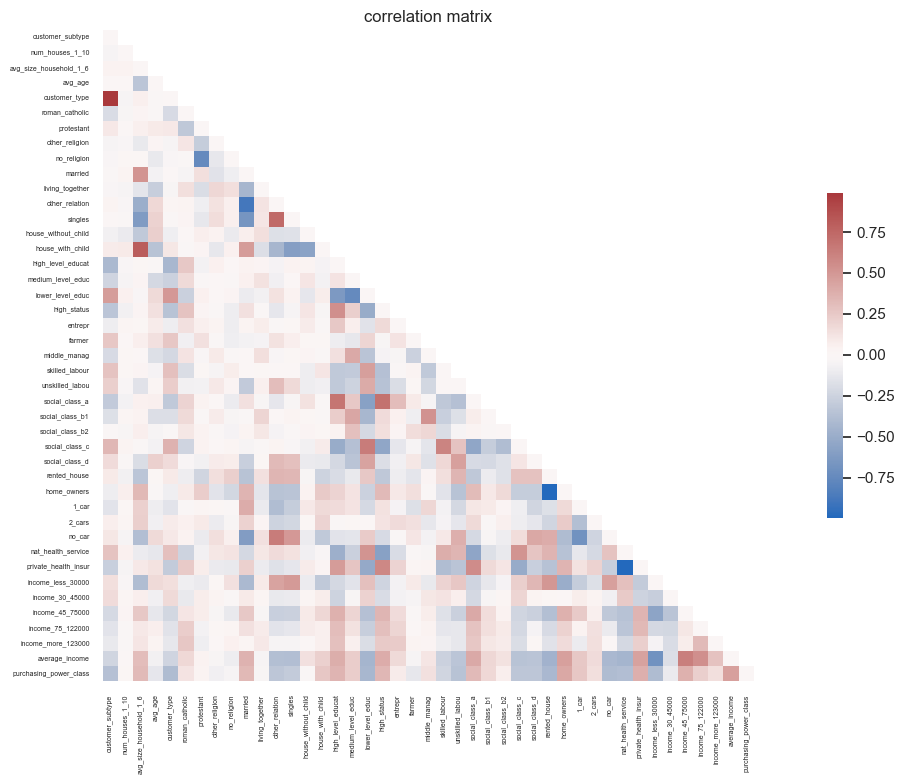

In [89]:
get_corr_matrix(dataset = data_train.iloc[:,0:43], isnumeric=False, size_figure=[12,10],limit=0)

In [90]:
top_correlation(data_train.iloc[:,0:43],metodo='spearman',limit_inf=0.7,limit_sup=1)

,Variable_1,Variable_2,Correlacion
0,rented_house,home_owners,-0.999549
1,nat_health_service,private_health_insur,-0.999203
2,customer_subtype,customer_type,0.987949
3,married,other_relation,-0.883178
4,avg_size_household_1_6,house_with_child,0.807787
5,medium_level_educ,lower_level_educ,-0.750358
6,protestant,no_religion,-0.745142
7,other_relation,singles,0.736695


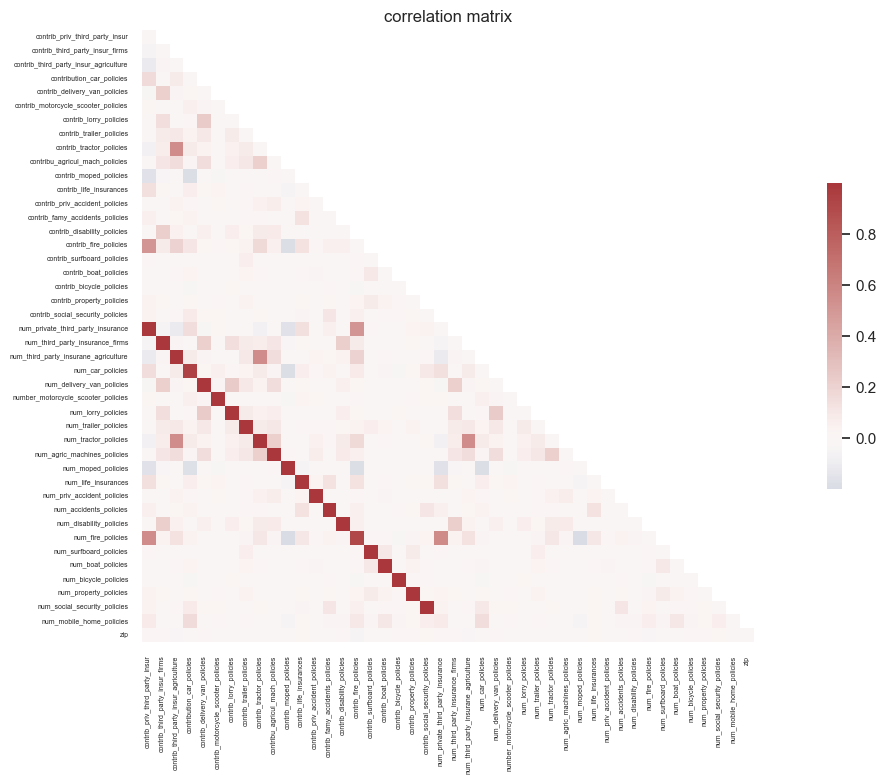

In [91]:
get_corr_matrix(dataset = data_train.iloc[:,43:], isnumeric=False, size_figure=[12,10],limit=0)

In [92]:
top_correlation(data_train.iloc[:,43:],metodo='spearman',limit_inf=0.80,limit_sup=1)

,Variable_1,Variable_2,Correlacion
0,contrib_surfboard_policies,num_surfboard_policies,1.000000
1,contrib_lorry_policies,num_lorry_policies,1.000000
2,contribu_agricul_mach_policies,num_agric_machines_policies,0.999999
3,contrib_disability_policies,num_disability_policies,0.999998
4,contrib_priv_accident_policies,num_priv_accident_policies,0.999996
5,contrib_famy_accidents_policies,num_accidents_policies,0.999995
6,contrib_boat_policies,num_boat_policies,0.999995
7,contrib_delivery_van_policies,num_delivery_van_policies,0.999994
8,contrib_property_policies,num_property_policies,0.999992
9,contrib_trailer_policies,num_trailer_policies,0.999989


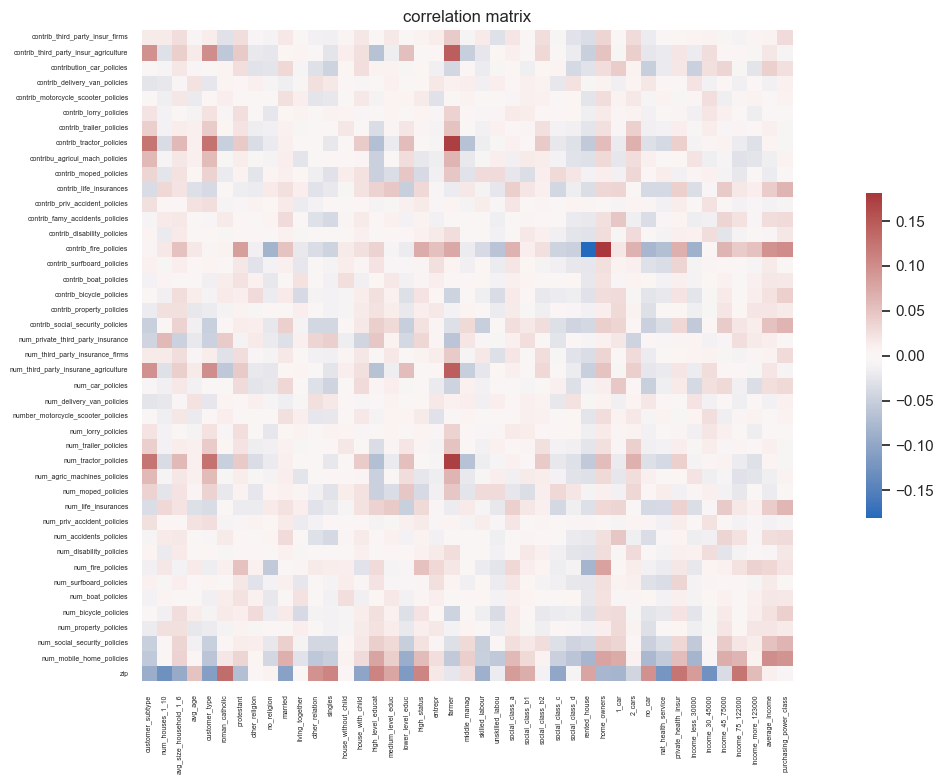

In [93]:
get_corr_matrix(dataset = data_train, isnumeric=False, size_figure=[12,10],limit=0,socioc_num=True)

In [94]:
top_correlation (data_train,metodo='spearman',limit_inf=0.07,limit_sup=1,socioc_num=True)

,Variable_1,Variable_2,Correlacion
0,contrib_fire_policies,rented_house,-0.181334
1,contrib_fire_policies,home_owners,0.181266
2,contrib_tractor_policies,farmer,0.172914
3,contrib_third_party_insur_agriculture,farmer,0.145206
4,contrib_fire_policies,purchasing_power_class,0.101672
5,contrib_third_party_insur_agriculture,customer_type,0.099752
6,contrib_fire_policies,average_income,0.095592
7,num_mobile_home_policies,purchasing_power_class,0.094735
8,contrib_fire_policies,income_less_30000,-0.085305
9,contrib_fire_policies,no_car,-0.079009


##### Cramers.
Replica los resultados de Spearman, pero si que encuentra, la alta relacion entre zip y las variables socioeconómicas.
Utilizamos el mismo esquema de mostrar todo el frame, las relaciones intragrupo y entre grupos.
Nos descubre la correlación de zip con las variables socioecómicas y un alta relación del poder de compra con el subtipo de cliente, que Sprerman no detectó.

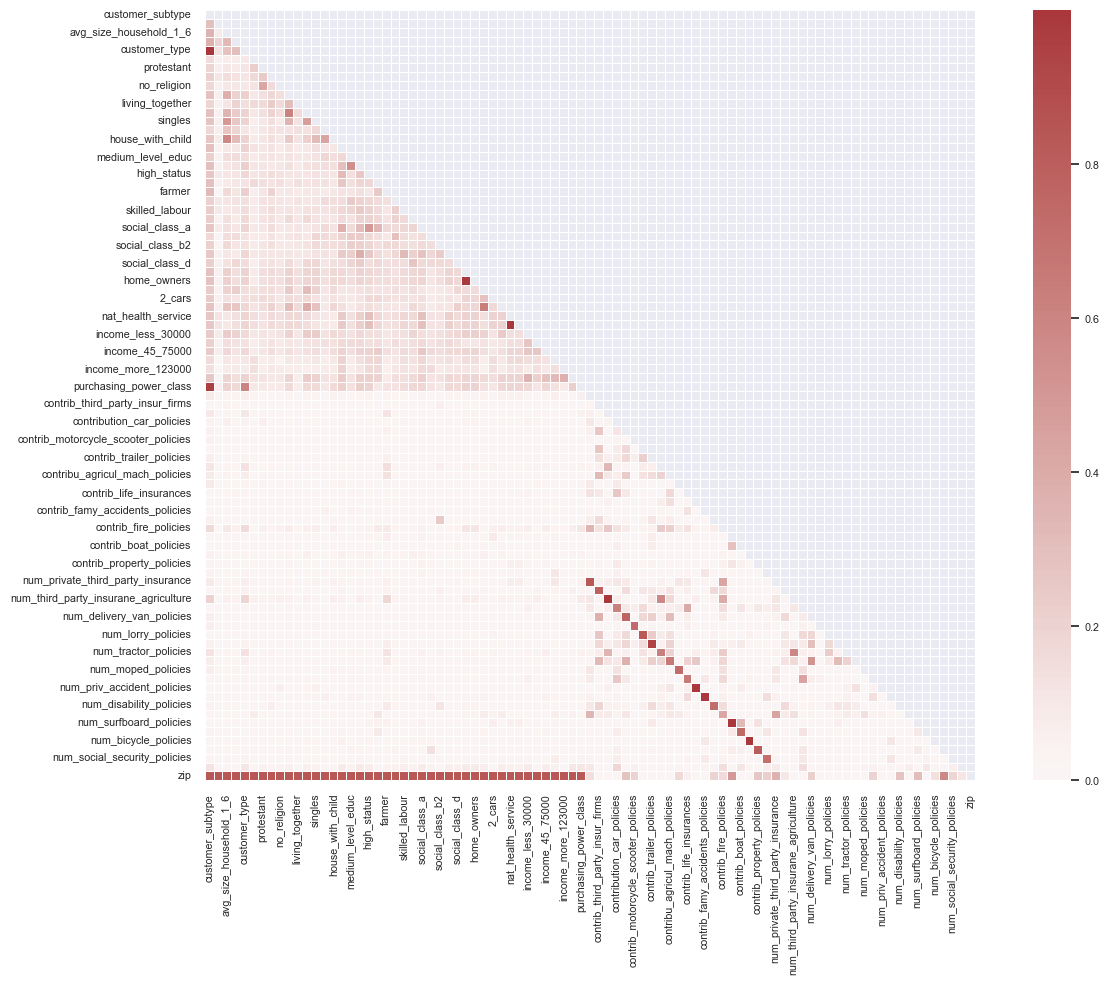

In [95]:
cramers_V_frame(df = data_train ,plot=True,limit=0)

In [96]:
top_correlation(data_train, metodo='cramers',limit_inf=0.9,limit_sup=1)

,Variable_1,Variable_2,Correlacion
0,contrib_famy_accidents_policies,num_accidents_policies,0.999914
1,contrib_surfboard_policies,num_surfboard_policies,0.999914
2,contrib_third_party_insur_agriculture,num_third_party_insurane_agriculture,0.999828
3,contrib_bicycle_policies,num_bicycle_policies,0.999828
4,contrib_priv_accident_policies,num_priv_accident_policies,0.999570
5,customer_subtype,customer_type,0.997416
6,nat_health_service,private_health_insur,0.994796
7,rented_house,home_owners,0.989916
8,customer_subtype,purchasing_power_class,0.953720
9,contrib_trailer_policies,num_trailer_policies,0.938590


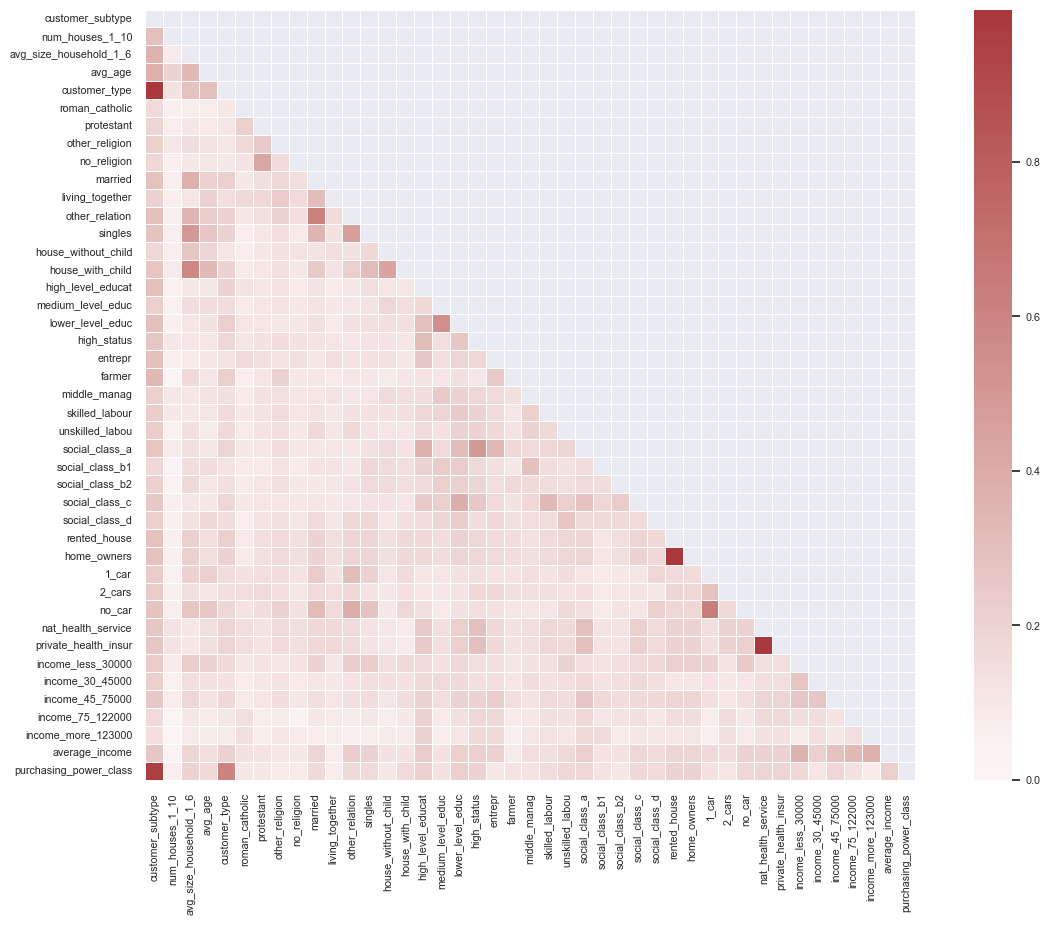

In [97]:
cramers_V_frame(df=data_train.iloc[:,0:43],plot= True,limit=0)

In [98]:
top_correlation(data_train.iloc[:,0:43],metodo='cramers',limit_inf=0.8,limit_sup=1)

,Variable_1,Variable_2,Correlacion
0,customer_subtype,customer_type,0.997416
1,nat_health_service,private_health_insur,0.994796
2,rented_house,home_owners,0.989916
3,customer_subtype,purchasing_power_class,0.953720


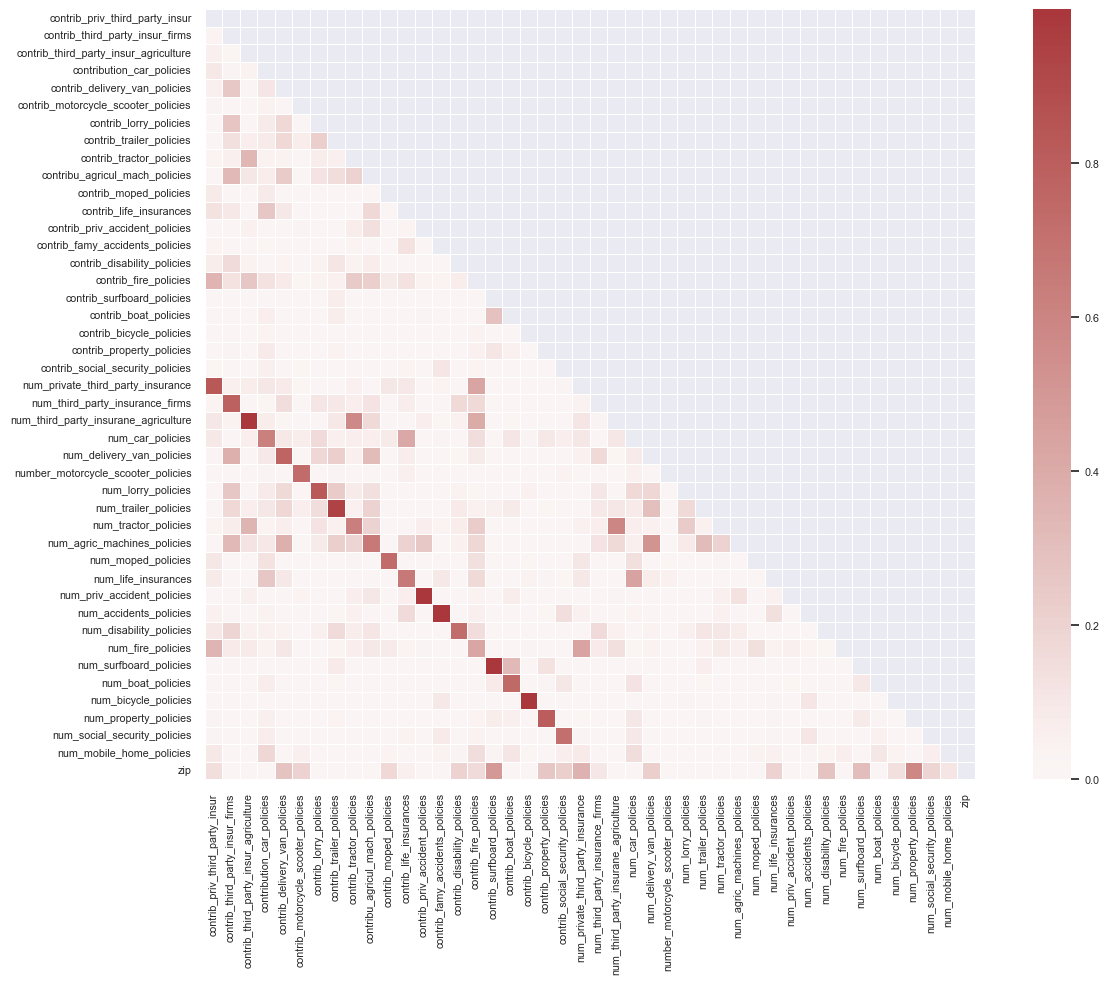

In [99]:
cramers_V_frame(df=data_train.iloc[:,43:],plot= True,limit=0)

In [100]:
top_correlation(data_train.iloc[:,43:],metodo='cramers',limit_inf=0.8,limit_sup=1)

,Variable_1,Variable_2,Correlacion
0,contrib_famy_accidents_policies,num_accidents_policies,0.999914
1,contrib_surfboard_policies,num_surfboard_policies,0.999914
2,contrib_third_party_insur_agriculture,num_third_party_insurane_agriculture,0.999828
3,contrib_bicycle_policies,num_bicycle_policies,0.999828
4,contrib_priv_accident_policies,num_priv_accident_policies,0.999570
5,contrib_trailer_policies,num_trailer_policies,0.938590
6,contrib_priv_third_party_insur,num_private_third_party_insurance,0.829672
7,contrib_lorry_policies,num_lorry_policies,0.826061
8,contrib_property_policies,num_property_policies,0.811348


La función para Cramers no está preparada para seleccionar plotear las relacioens intergrupos, mostramos los pares mas correlacionados entre grupos.

In [101]:
top_correlation(data_train.iloc[:,43:],metodo='cramers',limit_inf=0.8,limit_sup=1,socioc_num=True)

,Variable_1,Variable_2,Correlacion
0,num_surfboard_policies,contrib_surfboard_policies,0.999914
1,num_accidents_policies,contrib_famy_accidents_policies,0.999914
2,num_bicycle_policies,contrib_bicycle_policies,0.999828
3,num_third_party_insurane_agriculture,contrib_third_party_insur_agriculture,0.999828
4,num_priv_accident_policies,contrib_priv_accident_policies,0.999570
5,num_trailer_policies,contrib_trailer_policies,0.938590
6,num_lorry_policies,contrib_lorry_policies,0.826061
7,num_property_policies,contrib_property_policies,0.811348


Comprobemos el nivel de asociación de zip con las variables socioeconómicas.
Cramers encuentra una alta asCoILociación entre zip y las variables socioecómicas, lo cual no es de estrañar ya que zip fue contruida a través de estas variables.

In [102]:
columnas_computo = [item for item in range(0, 43)]+[86]
zip_corr=top_correlation (data_train.iloc[:,columnas_computo],metodo='cramers',limit_inf=0,limit_sup=1)
zip_corr[zip_corr.Variable_2=='zip']

,Variable_1,Variable_2,Correlacion
4,customer_subtype,zip,0.840846
5,income_less_30000,zip,0.838673
6,house_with_child,zip,0.838673
7,farmer,zip,0.838673
8,social_class_b1,zip,0.838673
9,singles,zip,0.838673
10,income_75_122000,zip,0.838673
11,rented_house,zip,0.838673
12,home_owners,zip,0.838673
13,other_relation,zip,0.838673


 ### Correlaciones con el target.
 Estudiamos las correlaciones entre el target y el resto de variables. Lo hacemos en dos fases, con respecto a las variables socioeconómicas de los códigos postales, y observamos asociaciones de cramers muy moderadas, las mas altas están en el entorno del 0.10 - 0.12.
Con respecto a las variables de cliente, las variables relacionadas con los seguros de comercialización masiva (autos e incendios) y el zip alcanzan niveles de asociación entre el 0.11  y el 0.18.

En términos generales, no descubrimos ninguna variable con un alto grado de asocación con la variable objetivo.

In [103]:
columnas_computo = [item for item in range(0, 43)]+[85]
zip_corr=top_correlation (data_train.iloc[:,columnas_computo],metodo='cramers',limit_inf=0,limit_sup=1)
zip_corr[zip_corr.Variable_2=='num_mobile_home_policies']

,Variable_1,Variable_2,Correlacion
598,customer_subtype,num_mobile_home_policies,0.121413
641,customer_type,num_mobile_home_policies,0.116983
665,purchasing_power_class,num_mobile_home_policies,0.114178
734,average_income,num_mobile_home_policies,0.105500
820,lower_level_educ,num_mobile_home_policies,0.091240
835,income_less_30000,num_mobile_home_policies,0.086176
837,social_class_a,num_mobile_home_policies,0.086082
847,rented_house,num_mobile_home_policies,0.083355
850,home_owners,num_mobile_home_policies,0.082884
856,high_level_educat,num_mobile_home_policies,0.081192


In [104]:
columnas_computo = [item for item in range(43,84)]+[86,85]
zip_corr=top_correlation (data_train.iloc[:,columnas_computo],metodo='cramers',limit_inf=0,limit_sup=1)
zip_corr[zip_corr.Variable_2=='num_mobile_home_policies']

,Variable_1,Variable_2,Correlacion
80,contribution_car_policies,num_mobile_home_policies,0.180517
105,contrib_fire_policies,num_mobile_home_policies,0.150810
107,num_car_policies,num_mobile_home_policies,0.149874
133,zip,num_mobile_home_policies,0.117138
138,contrib_boat_policies,num_mobile_home_policies,0.113464
155,num_boat_policies,num_mobile_home_policies,0.105157
178,contrib_priv_third_party_insur,num_mobile_home_policies,0.096739
190,num_private_third_party_insurance,num_mobile_home_policies,0.089186
236,num_fire_policies,num_mobile_home_policies,0.068772
241,contrib_social_security_policies,num_mobile_home_policies,0.066007


## Conclusiones.

Hemos estudiado a fondo los datos, conocememos su contenido y significado, y podemos encarar la siguiente fases con mucho mas conocimiento.
1) Como era de esperar, las variables socioeconomicas de las regiones de los cliente están muy poco relacionadas con los seguros que cada cliente compra.
2) Tendremos que estudiar sí la variable creada zip nos ayuda a discriminar quien contrtará un seguro de caravana.
3) Dentro de los datos de cliente, podemos eliminar las caracteristicas de contribución o las de número de pólizas por su altisíma correlación.
4) Parece que dentro de las variables de cliente, las relacionadas con los seguros de alta comercialización, incendios, autos y de terceras compañias cobrarán importancia.
5) Los seguros de muy baja comercilización, no parece que puedan aplicar a discriminar.
6) Parece muy recomendable la utilización de técnicas de sub o sobre muestreo en la construcción de modelos, dada la baja proporción de clientes con seguro de caravana.

En este caso, la tarea del EDA, que mejor nos ayudó a comprender los datos fueron las correlaciones,
ya que el estudio de faltantes se nos proporcionó realizardo, la consideración de ouliers nos obligaría a presecindir de la mayoría de las datos de cliente. El estudio de correlaciones, nos ayudó a comprender de manera significativa las relaciones entre los grupos de caracteristicas y dentro de cada grupo.
